# Exploration of Seattle's short rental market 
## Airbnb price prediction with Machine Learning.
*Keywords: Airbnb, Seattle, city, data, data science, design, geopandas, geospatial, gis, land use, livability, maps, matplotlib, modeling, neighborhood, networks, new urbanism, numpy, pandas, planning, python, smart cities, smart growth, urban, urban design, urban planning, visualization*

### 1. Project background and aim

 Airbnb is a internet marketplace for short-term home and apartment rentals. It allows you to, for example, rent out your home for a week while you’re away, or rent out your empty bedroom. One challenge that Airbnb hosts face is determining the optimal nightly rent price. In many areas, renters are presented with a good selection of listings and can filter by criteria like price, number of bedrooms, room type, and more. Since Airbnb is a market, the amount a host can charge is ultimately tied to market prices.
 
Although Airbnb provides hosts with general guidance, there are no easy to access methods to determine the best price to rent out a space. There is third-party software available, but for a hefty price (see an example on available software, click [here](https://beyondpricing.com/)).

One method could be to find a few listings that are similar to the place that will be up for rent, average the listed prices and set our price to this calculated average price. However, with the market being so dynamic, we would probably be looking to update the price regularly and this method can become tedious. 

Moreover, this may not be very accurate, as we are not taking into account other important factors that may give us a comparative advantage over other listings around us. This could be property characteristics such as number of rooms, bathrooms and extra services on offer. 

The aim of this project is to propose a data-driven solution, by using machine learning to predict rental price.

For this project, a predictor based on space will be introduced to the model: the property's proximity to certain venues. This will allow the model to put an implicit price on things such as living close to a bar or a supermarket.

### 2. Data Description

Airbnb does not release any data on the listings in its marketplace, a but separate group named [Inside Airbnb](http://insideairbnb.com/get-the-data.html) scrapes and compiles publicly available information about many cities Airbnb's listings from the Airbnb web-site. For this project, their data set scraped on April 1, 2021, on the city of Seattle, WA, USA is used. It contains information on all Seattle Airbnb listings that were live on the site on that date (over 4,200). Here's a [direct link](http://insideairbnb.com/seattle/).

The data has certain limitations. The most noticeable one is that it scrapes the advertised price rather than the actual price paid by previous customers. More accurate data is available for a fee in sites like [AirDNA](https://www.airdna.co/).

Each row in the data set is a listing available for rental in Airbnb's site for the specific city (observations). The columns describe different characteristics of each listing (features).

Some of the more important features this project will look into are the following: 

- `accommodates`: the number of guests the rental can accommodate
- `bedrooms`: number of bedrooms included in the rental
- `bathrooms`: number of bathrooms included in the rental
- `beds`: number of beds included in the rental
- `price`: nightly price for the rental
- `minimum_nights`: minimum number of nights a guest can stay for the rental
- `maximum_nights`: maximum number of nights a guest can stay for the rental
- `number_of_reviews`: number of reviews that previous guests have left

To model the spatial relationship between Airbnb rental prices and property proximity to certain venues, we use the [Foursquare API](https://developer.foursquare.com/) to access the city's venues and the street network, available though [OpenStreepMap (OSM)](https://www.openstreetmap.org/search?query=seattle#map=11/47.6077/-122.3421).

#### Install required packages

In [1]:
%matplotlib inline

# general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Geographical analysis
import geopandas as gpf #libspatialindex nees to be installed first
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import shapefile as shp
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
import descartes
import osmnet

# accessibility analysis
import time
from pandana.loaders import osm
from pandana.loaders import pandash5

# modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

#Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Set plot preference
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

print('Libraries imported.')


Bad key "text.kerning_factor" on line 4 in
C:\Users\Alena\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Libraries imported.


### 3. Cleaning and Pre-processing

This section was based and adapted from [this very clear and complete notebook](https://nbviewer.jupyter.org/github/L-Lewis/Airbnb-neural-network-price-prediction/blob/master/Airbnb-price-prediction.ipynb#Categorical-features).

In [2]:
#!pwd to check the working directory
raw_df = pd.read_csv('C:/Users/Alena/Desktop/Spring_Board/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/listings.csv/listings.csv')
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

The dataset contains 4213 Airbnb listings


id                        listing_url       scrape_id last_scraped  \
0  2318  https://www.airbnb.com/rooms/2318  20210318170758   2021-04-01   
1  9419  https://www.airbnb.com/rooms/9419  20210318170758   2021-03-19   
2  9531  https://www.airbnb.com/rooms/9531  20210318170758   2021-03-20   

                                                name  \
0  Casa Madrona - Urban Oasis 1 block from the park!   
1                Glorious sun room w/ memory foambed   
2                The Adorable Sweet Orange Craftsman   

                                         description  \
0  Now booking 30 night Minimum only. Please cont...   
1  Keeping you safe is our priority, we are adher...   
2  The Sweet Orange is a delightful and spacious ...   

                               neighborhood_overview  \
0  Madrona is a hidden gem of a neighborhood. It ...   
1  Lots of restaurants (see our guide book) bars,...   
2  The neighborhood is awesome!  Just far enough ...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/02973ad3-a7a3...     2536   
1  https://a0.muscache.com/pictures/56645186/e5fb...    30559   
2  https://a0.muscache.com/pictures/30470355/052c...    31481   

                                  host_url  host_name  host_since  \
0   https://www.airbnb.com/users/show/2536      Megan  2008-08-26   
1  https://www.airbnb.com/users/show/30559  Angielena  2009-08-09   
2  https://www.airbnb.com/users/show/31481     Cassie  2009-08-13   

                        host_location  \
0  Seattle, Washington, United States   
1  Seattle, Washington, United States   
2  Seattle, Washington, United States   

                                          host_about  host_response_time  \
0  I welcome guests from all walks of life and ev...      within an hour   
1  I am a visual artist who is  the  director of ...      within an hour   
2  The Sweet Orange reflects my passion and zest ...  within a few hours   

  host_response_rate host_acceptance_rate host_is_superhost  \
0               100%                  67%                 f   
1               100%                  80%                 t   
2               100%                  62%                 t   

                                  host_thumbnail_url  \
0  https://a0.muscache.com/im/pictures/user/016a1...   
1  https://a0.muscache.com/im/users/30559/profile...   
2  https://a0.muscache.com/im/users/31481/profile...   

                                    host_picture_url host_neighbourhood  \
0  https://a0.muscache.com/im/pictures/user/016a1...              Minor   
1  https://a0.muscache.com/im/users/30559/profile...         Georgetown   
2  https://a0.muscache.com/im/users/31481/profile...       The Junction   

   host_listings_count  host_total_listings_count  \
0                  2.0                        2.0   
1                  8.0                        8.0   
2                  0.0                        0.0   

                                  host_verifications host_has_profile_pic  \
0  ['email', 'phone', 'reviews', 'jumio', 'offlin...                    t   
1  ['email', 'phone', 'reviews', 'jumio', 'offlin...                    t   
2  ['email', 'phone', 'reviews', 'offline_governm...                    t   

  host_identity_verified                       neighbourhood  \
0                      t  Seattle, Washington, United States   
1                      t  Seattle, Washington, United States   
2                      t  Seattle, Washington, United States   

  neighbourhood_cleansed neighbourhood_group_cleansed  latitude  longitude  \
0                Madrona                 Central Area  47.61094 -122.29286   
1             Georgetown          Other neighborhoods  47.55017 -122.31937   
2         Fairmount Park                 West Seattle  47.55539 -122.38474   

               property_type        room_type  accommodates  bathrooms  \
0               Entire house  Entire home/apt             9        NaN   
1 

In [3]:
raw_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [4]:
raw_df.shape

(4213, 74)

#### Droping initial columns


Natural Language Processing will not be used in the creation of this model. Therefore, free text columns will be dropped for now, as will other columns which are not useful for predicting price (e.g. url, host name and other host-related features that are unrelated to the property).

In [5]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'host_thumbnail_url', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)

Columns with several `NULL` entries are dropped too. 

In [6]:
df.isna().sum()

id                                                 0
host_since                                       192
host_response_time                               765
host_response_rate                               765
host_acceptance_rate                             695
host_is_superhost                                192
host_listings_count                              192
host_total_listings_count                        192
host_has_profile_pic                             192
host_identity_verified                           192
neighbourhood                                   1160
neighbourhood_cleansed                             0
neighbourhood_group_cleansed                       0
latitude                                           0
longitude                                          0
property_type                                      0
room_type                                          0
accommodates                                       0
bathrooms                                     

In [7]:
df.drop(['host_acceptance_rate', 'neighbourhood', 'calendar_updated', 'license', 'bathrooms',
         'number_of_reviews_l30d'], axis=1, inplace=True)

df.set_index('id', inplace=True) # ID as index

`host_listings_count` and `host_total_listings_count` are the same in all but 192 cases. These cases are those where the value is `NaN`. Therefore one of these columns can be dropped. Other columns which split these into type of property will also be dropped, as they will be highly correlated (one will be the total of the others).

In [8]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:5]

192


host_since host_response_time host_response_rate host_is_superhost  \
id                                                                          
41401         NaN                NaN                NaN               NaN   
210316        NaN                NaN                NaN               NaN   
340706        NaN                NaN                NaN               NaN   
493591        NaN                NaN                NaN               NaN   
566435        NaN                NaN                NaN               NaN   

        host_listings_count  host_total_listings_count host_has_profile_pic  \
id                                                                            
41401                   NaN                        NaN                  NaN   
210316                  NaN                        NaN                  NaN   
340706                  NaN                        NaN                  NaN   
493591                  NaN                        NaN                  NaN   
566435                  NaN                        NaN                  NaN   

       host_identity_verified neighbourhood_cleansed  \
id                                                     
41401                     NaN        Mid-Beacon Hill   
210316                    NaN             Crown Hill   
340706                    NaN            Wallingford   
493591                    NaN             Crown Hill   
566435                    NaN             Crown Hill   

       neighbourhood_group_cleansed  latitude  longitude  \
id                                                         
41401                   Beacon Hill  47.56035 -122.31402   
210316          Other neighborhoods  47.70085 -122.36700   
340706          Other neighborhoods  47.65588 -122.33214   
493591          Other neighborhoods  47.70190 -122.36781   
566435          Other neighborhoods  47.70084 -122.36738   

                property_type        room_type  accommodates  bathrooms_text  \
id                                                                             
41401            Entire house  Entire home/apt             4          1 bath   
210316  Private room in house     Private room             2  4 shared baths   
340706       Entire apartment  Entire home/apt             4          1 bath   
493591  Private room in house     Private room             2   1 shared bath   
566435  Private room in house     Private room             2  4 shared baths   

        bedrooms  beds                                          amenities  \
id                                                                          
41401        1.0   2.0  ["Dryer", "TV", "Smoke alarm", "Iron", "Hair d...   
210316       1.0   1.0  ["TV", "Smoke alarm", "Patio or balcony", "Was...   
340706       1.0   1.0  ["TV", "Smoke alarm", "Patio or balcony", "Hig...   
493591       1.0   1.0  ["TV", "Smoke alarm", "Patio or balcony", "Sha...   
566435       1.0   1.0  ["TV", "Smoke alarm", "Shampoo", "Washer", "Ca...   

         price  minimum_nights  maximum_nights  minimum_minimum_nights  \
id                                                                       
41401   $95.00              30             365                    30.0   
210316  $60.00              30             365                    30.0   
340706  $70.00               4              30                     4.0   
493591  $50.00              30             180                    30.0   
566435  $65.00              30             365                    30.0   

        maximum_minimum_nights  minimum_maximum_nights  \
id                                                       
41401                     30.0                   365.0   
210316                    30.0                   365.0   
340706                     4.0                    30.0   
493591                    30.0                   180.0   
566435                    30.0                   365.0   

        maximum_maximum_nights  minimum_nights_avg_ntm  \
id            

In [9]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 
         'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 
         'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

There are multiple columns for property location, including an attempt by the site that originally scraped the data to clean up the neighbourhood locations. Some of these columns can be dropped. Because all of the listings are in Seattle, columns relating to city and country can be dropped. One column for area will be kept, `neighboorhood_cleansed`.

In [10]:
df.drop(['latitude', 'longitude'], axis=1, inplace=True)

There are multiple columns for minimum and maximum night stays, but the two main ones will be used as there are few differences between e.g. `minimum_nights` and `minimum_minimum_nights`. The latter presumably refers to the fact that min/max night stays can vary over the year. The default (i.e. most frequently applied) min/max night stay values will be used instead.

In [11]:
sum((df.minimum_nights == df.minimum_minimum_nights) == False)

345

In [12]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
         'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

Since we droped the bathhrooms column because of missing data, we can use the 'bathrooms_text' column to extract number of buthrooms. 

In [13]:
df.bathrooms_text = df.bathrooms_text.str.replace('baths', '').str.replace('bath', '').str.replace('shared', '').str.replace('private', '').str.replace('Half-', '0.5').str.replace('Private half-', '0.5').str.replace('Shared half-', '0.5').str.replace(' ', '')
df.bathrooms_text.unique()

array(['2.5', '3', '1', '2', '1.5', '4', '4.5', nan, '0', '3.5', '0.5',
       '5', '6', '16'], dtype=object)

In [14]:
df.bathrooms_text = df.bathrooms_text.astype(float)

In [15]:
df.bathrooms_text.unique()

array([ 2.5,  3. ,  1. ,  2. ,  1.5,  4. ,  4.5,  nan,  0. ,  3.5,  0.5,
        5. ,  6. , 16. ])

In [16]:
#Renaming the 'bathrooms_text' column to 'bathrooms'
df = df.rename(columns={'bathrooms_text':'bathrooms'})

Checking whether boolean and categorical features contain sufficient numbers of instances in each category to make them worth including:

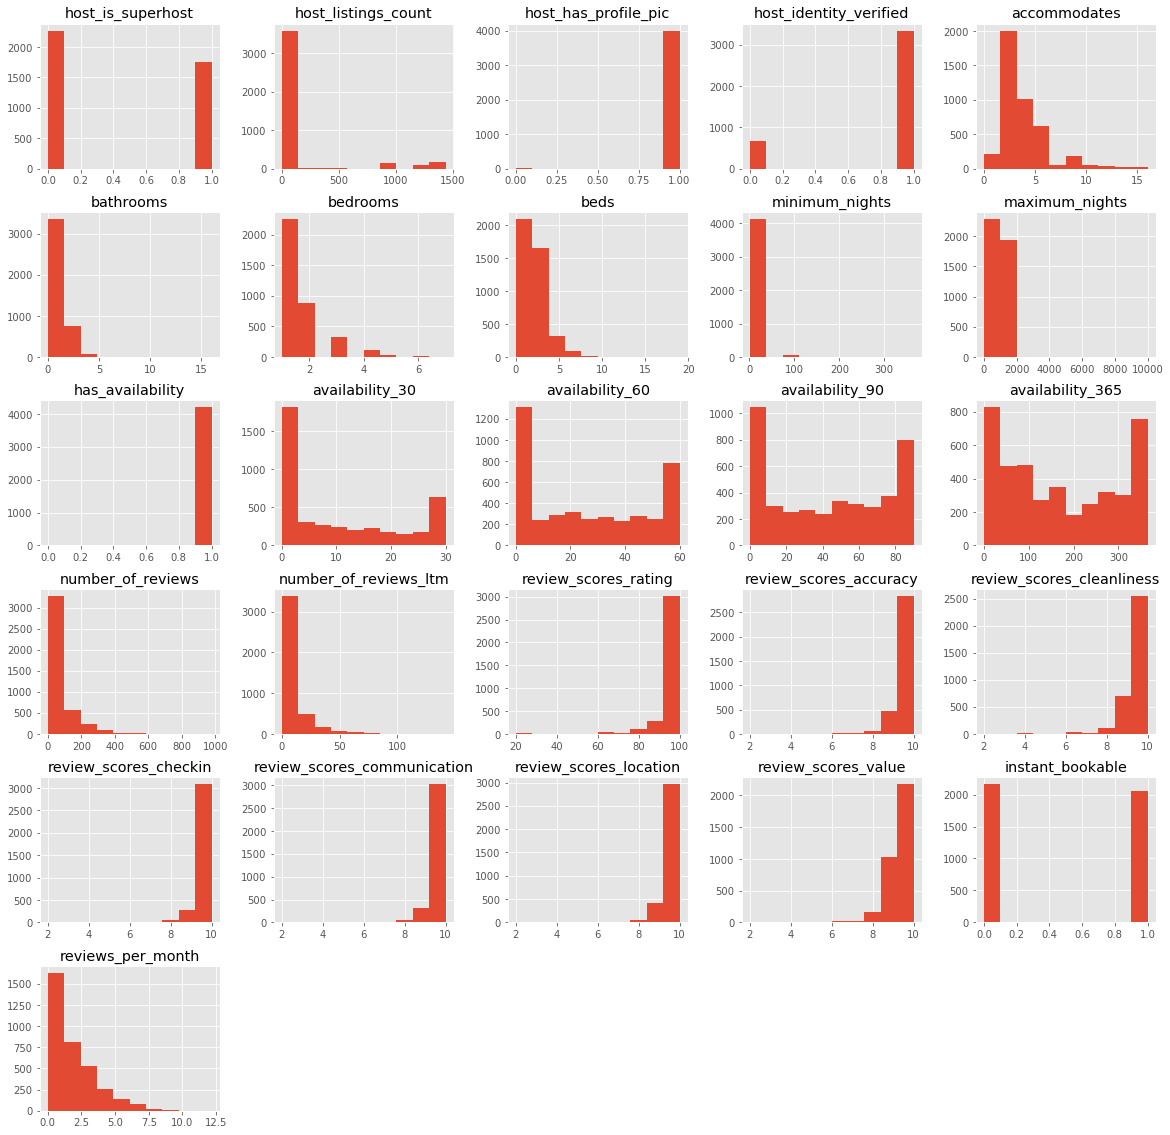

In [17]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

From the above, it can be seen that several columns only contain one category and can be dropped:

In [18]:
df.drop(['has_availability', 'host_has_profile_pic', ], axis=1, inplace=True)

#### Variables description:

- `host_since` - date that the host first joined Airbnb

- `host_response_time` - average amount of time the host takes to reply to messages

- `host_response_rate` - proportion of messages that the host replies to

- `host_is_superhost` - whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb

- `host_listings_count` - how many listings the host has in total

- `host_identity_verified` - whether or not the host has been verified with id

- `neighbourhood_cleansed` - the Seattle borough the property is in

- `property_type` - type of property, e.g. house or flat

- `room_type` - type of listing, e.g. entire home, private room or shared room

- `accommodates` - how many people the property accommodates

- `bathrooms` - number of bathrooms

- `bedrooms` - number of bedrooms

- `beds` - number of beds

- `amenities` - list of amenities

- `price` - nightly advertised price (the target variable)

- `minimum_nights` - the minimum length of stay

- `maximum_nights` - the maximum length of stay

- `availability_30` - how many nights are available to be booked in the next 30 days

- `availability_60` - how many nights are available to be booked in the next 60 days

- `availability_90` - how many nights are available to be booked in the next 90 days

- `availability_365` - how many nights are available to be booked in the next 365 days

- `number_of_reviews` - the number of reviews left for the property

- `number_of_reviews_ltm` - the number of reviews left for the property in the last twelve months

- `first_review` - the date of the first review

- `last_review` - the date of the most recent review

- `review_scores_rating` - guests can score properties overall from 1 to 5 stars

- `review_scores_accuracy` - guests can score the accuracy of a property's description from 1 to 5 stars

- `review_scores_cleanliness` - guests can score a property's cleanliness from 1 to 5 stars

- `review_scores_checkin` - guests can score their check-in from 1 to 5 stars

- `review_scores_communication` - guests can score a host's communication from 1 to 5 stars

- `review_scores_location` - guests can score a property's location from 1 to 5 stars

- `review_scores_value` - guests can score a booking's value for money from 1 to 5 stars

- `instant_bookable` - whether or not the property can be instant booked (i.e. booked straight away, without having to message the host first and wait to be accepted)

- `reviews_per_month` - calculated field of the average number of reviews left by guest each month

#### Cleaning individual columns

##### `host_since`

This is a datetime column, and will be converted into a measure of the number of days that a host has been on the platform, measured from the date that the data was scraped (April 1, 2021). The original column will be left in initially for EDA, and dropped later.

In [19]:
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (pd.datetime(2021, 4, 1) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 2063.0
Median days as host: 2089.0


##### `host_response_time`

About a third of rows don't have a value for `host_response_time`, and the majority of these have also not yet been reviewed. Therefore this section of the data set consists primarily of properties which have not yet had a completed stay (most likely properties which have not yet had a booking, although may also include properties that have a booking currently occuring). Although this is a considerable proportion of the dataset, these listings will be retained in the data because they are still legitimate properties with advertised prices, and are still part of the comparative market when considering the price for which to advertise your Airbnb listing. However, if the dataset being used had the actual average price paid as its target, it would be necessary to drop these rows because they would not have a value, as they have not yet been booked.

It is worth noting, however, that this group of listings probably also contains a large number of 'inactive' listings. These are properties which have been speculatively listed on Airbnb but either have their calendars closed (so no stays can be booked), or have prices which are notably higher than other properties in their area.
Because `host_response_time` is unknown for so many listings, it will be retained as its own category, `'unknown'`.

In [20]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
len(df[df.loc[ :,['host_response_time', 'first_review'] ].isnull().sum(axis=1) == 2])

Null values: 765
Proportion: 18.2%


102

In [21]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

within an hour        0.619748
unknown               0.181581
within a few hours    0.102777
within a day          0.076905
a few days or more    0.018989
Name: host_response_time, dtype: float64

##### `host_response_rate`

A similar story is true for *host_response_rate*, with about a third of values being null. This will also be kept as its own category, after grouping other values into meaningful groups (i.e. transforming this into a categorical feature, rather than a numerical one). Because about 70% of hosts respond 100% of the time, this will be kept as its own category, and other values will be grouped into bins.

In [22]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 765
Proportion: 18.2%


In [23]:
# Removing the % sign from the host_response_rate string and converting to a float
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 95.0
Median host response rate: 100.0
Proportion of 100% host response rates: 69.2%


In [24]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, 
                               bins=[0, 50, 90, 99, 100], 
                               labels=['0-49%', '50-89%', '90-99%', '100%'], 
                               include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
#df.host_response_rate.replace("nan", 'unknown', inplace=True)
df.host_response_rate.fillna('unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

100%       2385
unknown     765
90-99%      671
50-89%      281
0-49%       111
Name: host_response_rate, dtype: int64

In [25]:
df.host_response_rate.unique()

array(['100%', '90-99%', '50-89%', 'unknown', '0-49%'], dtype=object)

##### `host_is_superhost`

There are 192 row with no values for each of three different host-related features. These rows will be dropped.

In [26]:
# Number of rows without a value for multiple host-related columns
len(df[df.loc[ :,['host_is_superhost', 'host_listings_count', 
                  'host_identity_verified'] ].isnull().sum(axis=1) == 3])

192

In [27]:
df.dropna(subset=['host_is_superhost'], inplace=True)

##### `property_type`

Some cleaning of property types is required as there are a large number of categories with only a few listings. The categories `Apartment`, `House` and `Other` will be used, as most properties can be classified as either apartment or house.

In [28]:
df.property_type.value_counts()

Entire apartment                      1163
Entire house                           688
Entire guest suite                     446
Private room in house                  402
Entire condominium                     316
Entire serviced apartment              191
Entire townhouse                       184
Entire guesthouse                      158
Private room in townhouse               82
Private room in apartment               54
Room in boutique hotel                  41
Entire cottage                          34
Shared room in house                    34
Entire loft                             32
Private room in guest suite             30
Entire bungalow                         29
Private room in condominium             17
Tiny house                              14
Room in serviced apartment              12
Private room in bed and breakfast       10
Private room in bungalow                10
Entire villa                             6
Houseboat                                6
Room in apa

In [29]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Entire apartment': 'Apartment',
    'Entire house': 'House',
    'Entire condominium': 'Apartment',
    'Entire serviced apartment': 'Apartment',
    'Entire guesthouse': 'House',
    'Entire townhouse': 'House',
    'Entire cottage': 'House',
    'Entire loft': 'Apartment',
    'Entire bungalow': 'House',
    'Entire villa': 'House',
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [30]:
df.property_type.value_counts()

Apartment    1702
Other        1206
House        1113
Name: property_type, dtype: int64

##### `bathrooms`, `bedrooms` and `beds`

Missing values will be replaced with the median (to avoid strange fractions).

In [31]:
df.isna().sum()

host_since                        0
host_response_time                0
host_response_rate                0
host_is_superhost                 0
host_listings_count               0
host_identity_verified            0
neighbourhood_cleansed            0
neighbourhood_group_cleansed      0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         4
bedrooms                        548
beds                             35
amenities                         0
price                             0
minimum_nights                    0
maximum_nights                    0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
number_of_reviews_ltm             0
first_review                    689
last_review                     689
review_scores_rating            697
review_scores_accuracy      

In [32]:
df.bedrooms.value_counts()

1.0    2146
2.0     839
3.0     314
4.0     117
5.0      39
6.0      13
7.0       5
Name: bedrooms, dtype: int64

In [33]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

##### `amenities`

Amenities is a list of additional features in the property, i.e. whether it has a TV or parking. Examples are below:

In [34]:
# Example of amenities listed
df.amenities[:1].values

array(['["Heating", "Kitchen", "Host greets you", "Indoor fireplace", "Hot water", "Garden or backyard", "Coffee maker", "Free parking on premises", "High chair", "Fire extinguisher", "Pack \\u2019n Play/travel crib", "Smoke alarm", "Iron", "First aid kit", "Shampoo", "Dedicated workspace", "Lake access", "Refrigerator", "Luggage dropoff allowed", "Dishwasher", "Oven", "Patio or balcony", "Stove", "Carbon monoxide alarm", "Dishes and silverware", "Washer", "Children\\u2019s books and toys", "Dryer", "Essentials", "Hangers", "Hair dryer", "Free street parking", "Long term stays allowed", "Wifi", "Cooking basics", "Microwave"]'],
      dtype=object)

In [35]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('\\u2013', '')
amenities_list_string = amenities_list_string.replace('\\u2014', ',')
amenities_list_string = amenities_list_string.replace('\\u2019s', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = [x.split('] [') for x in amenities_set]
amenities_set = [l for x in amenities_set for l in x]
amenities_set = set(amenities_set)
amenities_set

{'$14 per person per day',
 '1 space',
 '10 spaces',
 '100 spaces',
 '100% Vegan',
 '100% Vegan and Cruelty-Free body soap',
 '2 Drawers',
 '2 Shelves',
 '20\\ HDTV',
 '24-hour fitness center',
 '26\\ HDTV with standard cable',
 '27\\ TV',
 '27\\ TV with Netflix',
 '3 Door Bins',
 '3 spaces',
 '3/4 size fridge + mini fridge',
 '32\\ HDTV',
 '32\\ HDTV with Roku',
 '32\\ HDTV with standard cable',
 '32\\ TV',
 '32\\ TV with Netflix',
 '32\\ TV with Roku',
 '35\\ HDTV with Amazon Prime Video',
 '365 Whole Foods Conditioner conditioner',
 '365 Whole Foods Shampoo shampoo',
 '39\\ HDTV with Netflix',
 '40\\ HDTV with Amazon Prime Video',
 '40\\ HDTV with Chromecast',
 '40\\ HDTV with Netflix',
 '40\\ HDTV with standard cable',
 '40\\ TV with Roku',
 '42\\ HDTV',
 '42\\ HDTV with Amazon Prime Video',
 '42\\ HDTV with Apple TV',
 '42\\ HDTV with Netflix',
 '42\\ HDTV with Roku',
 '43\\ HDTV with Amazon Prime Video',
 '43\\ HDTV with Netflix',
 '43\\ HDTV with premium cable',
 '43\\ HDTV with

In the list above, some amenities are more important than others (i.e. a balcony is more likely to increase price than a fax machine), and some are likely to be fairly uncommon (i.e.. 'Electric profiling bed'). For the purpose of this project, amenities will be extracted based on quick research into which amenities are considered by guests a selection of the more important as well as personal experience. These will be further investigated in the EDA section. For example, if it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in helping explain differences in prices.

The amenities chosen are (slashes indicate separate categories that can be combined):

- 24-hour check-in
- Air conditioning/central air conditioning
- Amazon Echo/Apple TV/DVD player/game console/Netflix/projector and screen/smart TV (i.e. non-basic electronics)
- BBQ grill/fire pit/propane barbeque
- Balcony/patio or balcony
- Beach view/beachfront/lake access/mountain view/ski-in ski-out/waterfront (i.e. great location/views)
- Bed linens
- Breakfast
- Cable TV/TV
- Coffee maker/espresso machine
- Cooking basics
- Dishwasher/Dryer/Washer/Washer and dryer
- Elevator
- Exercise equipment/gym/private gym/shared gym
- Family/kid friendly, or anything containing 'children'
- Free parking on premises/free street parking/outdoor parking/paid parking off premises/paid parking on premises
- Garden or backyard/outdoor seating/sun loungers/terrace
- Host greets you
- Hot tub/jetted tub/private hot tub/sauna/shared hot tub/pool/private pool/shared pool
- Internet/pocket wifi/wifi
- Long term stays allowed
- Pets allowed/cat(s)/dog(s)/pets live on this property/other pet(s)
- Private entrance
- Safe/security system
- Self check-in
- Smoking allowed
- Step-free access/wheelchair accessible, or anything containing 'accessible'
- Suitable for events

In [36]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

One way to reduce the number of features is to remove the amenities which add relatively little information, or are relatively unhelpful in differentiating between different listings. Amenity features where either the true or the false category contains fewer than 10% of listings will be removed.

In [37]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,35:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,35:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'high_end_electronics', 'nature_and_views', 'breakfast', 'host_greeting', 'hot_tub_sauna_or_pool', 'pets_allowed', 'secure', 'self_check_in', 'smoking_allowed', 'accessible', 'event_suitable']


##### `price`

Price will be converted to an integer. Currently it is a string because there is a currency sign.

In [38]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

##### `availability`

There are multiple different measures of availability, which will be highly correlated with each other. Only one will be retained, availability for 365 days (`availability_365`).

In [39]:
df.drop(['availability_30', 'availability_60', 'availability_90'], axis=1, inplace=True)

##### `first_review` and `last_review`

Almost 20 percent of listings have not had a review written for them. This is too large a proportion of the dataset to drop, and dropping the columns would lose a lot of useful information because reviews are very important in people's decisions to book, and therefore price.

This is also too large a proportion of the dataset to simply replace with median/mean values, as this would skew the distribution substantially. Also, the missing values here are not really missing values, as the fact that they are `NaN`s is meaningful - it tells us that these are new or previously unbooked listings that have not had reviews yet. In order to make the resulting model work able to predict prices for any Airbnb listing, including brand new listings, is is actually beneficial to keep them in. Therefore, these will be kept as an `unknown` category, and the feature will have to be treated as categorical (and therefore one-hot encoded) rather than numerical.

In [40]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 17.1%
Null values in 'review_scores_rating': 17.3%


In [41]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (pd.datetime(2021, 4, 1) - df.first_review).astype('timedelta64[D]')

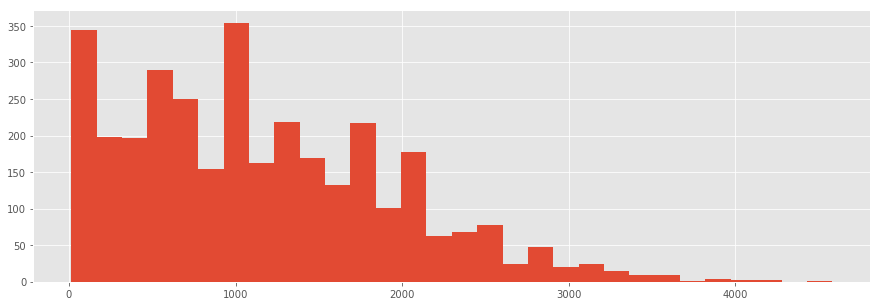

In [42]:
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [43]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [44]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

Same process for `last_review`

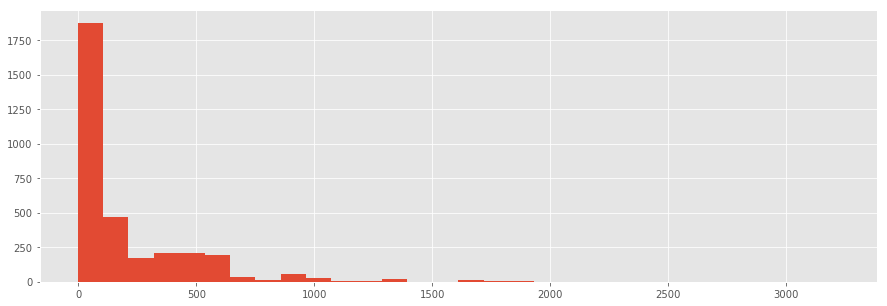

In [45]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (pd.datetime(2021, 4, 1) - df.last_review).astype('timedelta64[D]')

# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [46]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [47]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

##### `review` ratings columns

As above, listings without reviews will be kept and replaced with `unknown`. Other ratings will be grouped into bins. The histograms below were produced in order to decide on useful bins. The majority of ratings are 9 or 10 out of 10, as also seen in the value count below. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together (as this is, by Airbnb standards, a 'low' rating).

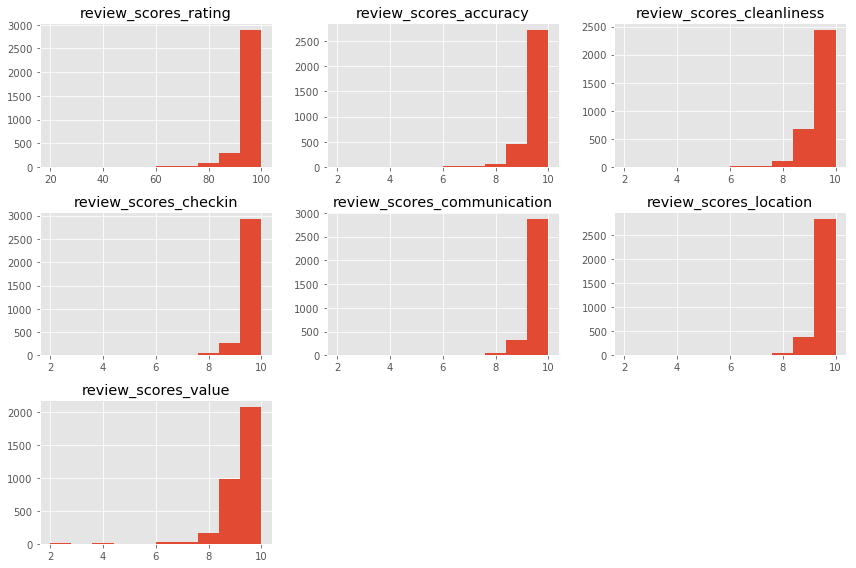

In [48]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [49]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [50]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [51]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

##### `number_of_reviews_ltm` and `reviews_per_month`

These will be highly correlated with `number_of_reviews` and `reviews_per_month` and so will be dropped.

In [52]:
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

In [53]:
df.shape

(4021, 47)

In [54]:
df.head()
df.dtypes

host_since                      datetime64[ns]
host_response_time                      object
host_response_rate                      object
host_is_superhost                      float64
host_listings_count                    float64
host_identity_verified                 float64
neighbourhood_cleansed                  object
neighbourhood_group_cleansed            object
property_type                           object
room_type                               object
accommodates                             int64
bathrooms                              float64
bedrooms                               float64
beds                                   float64
price                                    int64
minimum_nights                           int64
maximum_nights                           int64
availability_365                         int64
number_of_reviews                        int64
first_review                    datetime64[ns]
review_scores_rating                    object
review_scores

In [55]:
# Save cleaned dataset
listings_cleaned = df.to_csv('C:/Users/Alena/Desktop/Spring_Board/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/listings_cleaned.csv', index=id, header=True)

### 4. Exploratory Data Analysis

#### Time Series

Time is an important factor to consider in a model when we wish to predict prices or trends. Enter **time series**. A time series is simply a series of data points ordered in time. In a time series, time is often the independent variable and the goal is usually to make a forecast for the future. There are also other questions that come to play when dealing with time series. For example: Is there any *seasonality* to the price? Is it *stationary*? Even though we may not be able to include this aspect into our model, it is good to explore it to be aware of it and be able to make recommendations for future research. Thus, in this section, we will explore this aspect of the data.

In [56]:
# Read dataset
df = pd.read_csv('C:/Users/Alena/Desktop/Spring_Board/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/listings_cleaned.csv', index_col=0)

In [57]:
df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])

In [58]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")


Of the Airbnb hosts that are still listing on the site, the first joined on 26 August 2008, and the most recent joined on 06 March 2021.


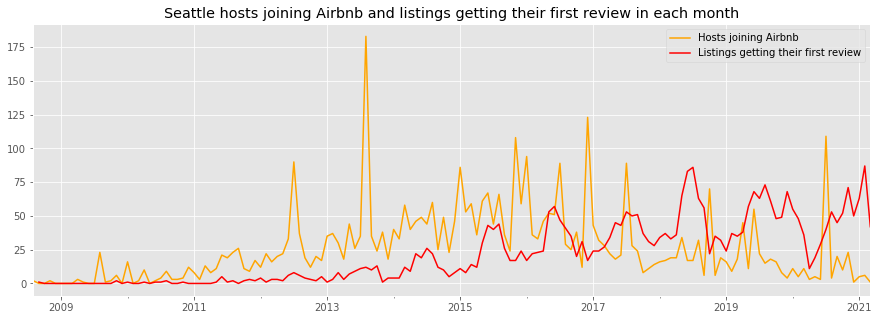

In [59]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='red')
plt.title('Seattle hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2008-08-26', '2021-03-06') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [60]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [61]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

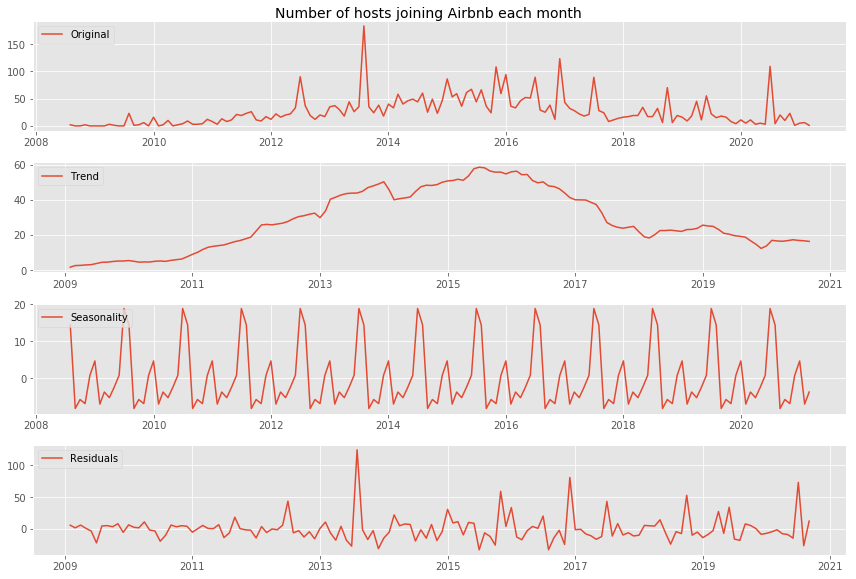

In [62]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

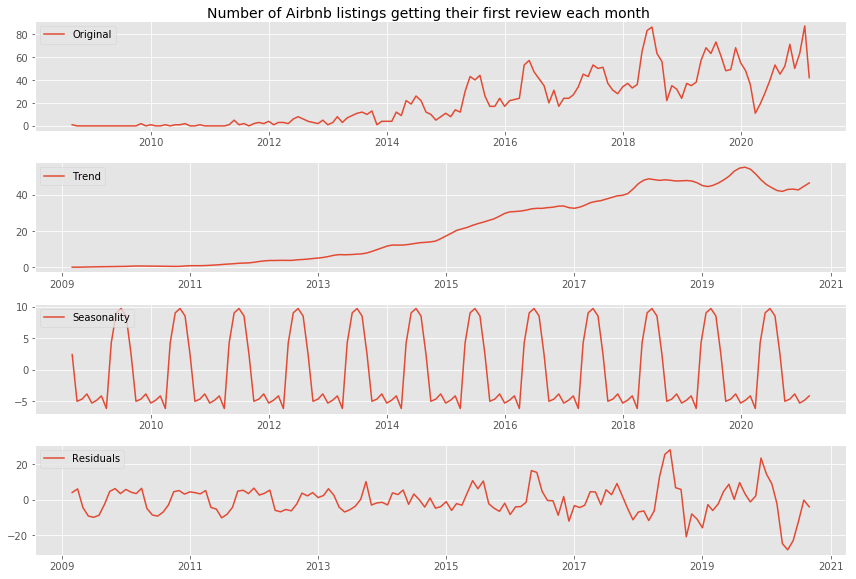

In [63]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

As seen above, there is a clear seasonality. Every year, you see a peak towards hosts joining around the middle of the year (summer), and the lowest points are the beginning and the end of each year. There is a big peak in the number of hosts joining Airbnb between 2013 and 2014. Indeed, there has been a fast growth of Airbnb since middle 2013.

Another important pattern to observe is the number of listings per owner/host. There are a number of professional Airbnb management companies which host a large number of listings under a single host profile. However, there is no consistent upwards trend in the average number of properties managed by each host.

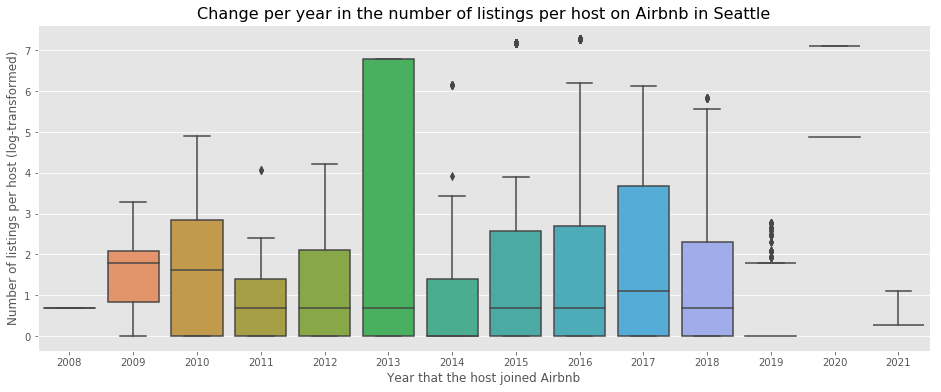

In [64]:
plt.figure(figsize=(16,6))
sns.boxplot(df.host_since.dt.year, np.log(df.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in Seattle', fontsize=16)
plt.show()

In [65]:
print("Average number of listings per host per year on Airbnb in Seattle:")
print(round(df.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per host per year on Airbnb in Seattle:
host_since
2008-01-01      2.00
2009-01-01      7.08
2010-01-01     10.95
2011-01-01      3.42
2012-01-01     17.24
2013-01-01    238.57
2014-01-01      9.74
2015-01-01    146.35
2016-01-01    218.13
2017-01-01     30.05
2018-01-01     16.12
2019-01-01      3.58
2020-01-01    583.33
2021-01-01      0.83
Freq: AS-JAN, Name: host_listings_count, dtype: float64


In [66]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

host_since  host_listings_count
id                                      
45655638 2017-01-16                206.0
41645029 2018-12-04                264.0
36768880 2018-08-31                342.0
48541315 2017-03-20                458.0
23533370 2014-12-14                475.0
29798498 2016-10-21                496.0
46794214 2013-08-30                882.0
47455178 2020-07-28               1225.0
35641936 2015-11-02               1318.0
48727524 2016-12-16               1435.0

In term of changes in prices over time, the average price per night for Airbnb listings in Seattle has increased slightly over the last 10 years. In particular, the top end of property prices has increased, resulting in a larger increase in the mean price compared to the median. The mean price in 2010 was 119.29 and the median 73.0, whereas the mean price in 2020 (the last complete year of data) was 122 and the median 104.

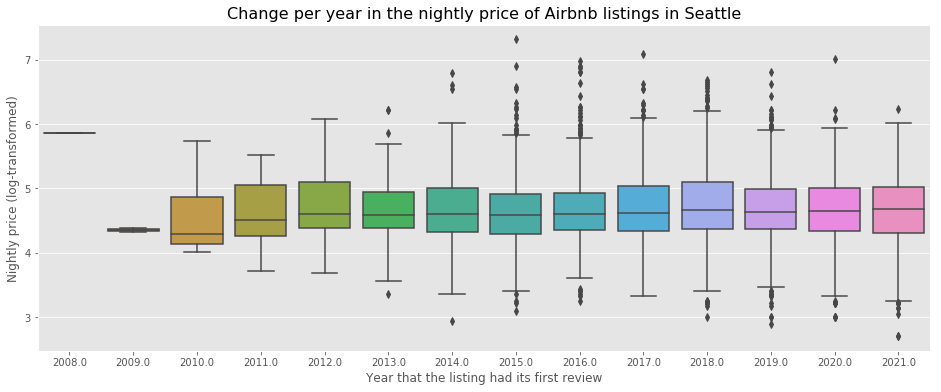

In [67]:
plt.figure(figsize=(16,6))
sns.boxplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in Seattle', fontsize=16)
plt.show()

In [68]:
print("Mean nightly price of listings in each year on Airbnb in Seattle:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in Seattle:
first_review
2008-01-01    349.00
2009-01-01     77.50
2010-01-01    119.29
2011-01-01    109.00
2012-01-01    132.74
2013-01-01    127.21
2014-01-01    132.98
2015-01-01    133.27
2016-01-01    138.68
2017-01-01    136.76
2018-01-01    140.08
2019-01-01    125.93
2020-01-01    121.91
2021-01-01    121.99
Name: price, dtype: float64


In [69]:
print("Median nightly price of listings in each year on Airbnb in Seattle:")
print(round(df.set_index('first_review').price.resample('YS').median(),2))

Median nightly price of listings in each year on Airbnb in Seattle:
first_review
2008-01-01    349.0
2009-01-01     77.5
2010-01-01     73.0
2011-01-01     91.5
2012-01-01    100.0
2013-01-01     98.0
2014-01-01     99.0
2015-01-01     97.5
2016-01-01     99.0
2017-01-01    101.0
2018-01-01    106.0
2019-01-01    103.0
2020-01-01    104.0
2021-01-01    107.5
Name: price, dtype: float64


In [70]:
# Dropping host_since and first_review as they are no longer needed
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

#### Numerical Features

In [71]:
df.describe()

host_is_superhost  host_listings_count  host_identity_verified  \
count        4021.000000          4021.000000             4021.000000   
mean            0.434718           127.110420                0.832131   
std             0.495782           358.149356                0.373796   
min             0.000000             0.000000                0.000000   
25%             0.000000             1.000000                1.000000   
50%             0.000000             2.000000                1.000000   
75%             1.000000            10.000000                1.000000   
max             1.000000          1435.000000                1.000000   

       accommodates    bathrooms     bedrooms         beds        price  \
count   4021.000000  4021.000000  4021.000000  4021.000000  4021.000000   
mean       3.728426     1.311365     1.514549     1.919920   135.337727   
std        2.346875     0.730070     0.893926     1.416868   121.221434   
min        0.000000     0.000000     1.000000     0.000000     0.000000   
25%        2.000000     1.000000     1.000000     1.000000    79.000000   
50%        3.000000     1.000000     1.000000     2.000000   109.000000   
75%        4.000000     1.500000     2.000000     2.000000   155.000000   
max       16.000000    16.000000     7.000000    19.000000  3858.000000   

       minimum_nights  maximum_nights  availability_365  number_of_reviews  \
count     4021.000000     4021.000000       4021.000000        4021.000000   
mean        15.950759      595.847302        167.769958          62.586173   
std         19.588035      527.023276        127.408588          92.499775   
min          1.000000        3.000000          0.000000           0.000000   
25%          2.000000       60.000000         53.000000           2.000000   
50%          4.000000      365.000000        149.000000          23.000000   
75%         30.000000     1125.000000        291.000000          85.000000   
max        365.000000    10000.000000        365.000000         978.000000   

       instant_bookable  host_days_active  air_conditioning          bbq  \
count       4021.000000       4021.000000       4021.000000  4021.000000   
mean           0.483959       2062.833375          0.359115     0.203183   
std            0.499805        910.878988          0.479801     0.402418   
min            0.000000         26.000000          0.000000     0.000000   
25%            0.000000       1505.000000          0.000000     0.000000   
50%            0.000000       2089.000000          0.000000     0.000000   
75%            1.000000       2767.000000          1.000000     0.000000   
max            1.000000       4601.000000          1.000000     1.000000   

           balcony    bed_linen           tv  coffee_machine  cooking_basics  \
count  4021.000000  4021.000000  4021.000000     4021.000000     4021.000000   
mean      0.424521     0.600597     0.846307        0.712261        0.608555   
std       0.494332     0.489837     0.360699        0.452765        0.488134   
min       0.000000     0.000000     0.000000        0.000000        0.000000   
25%       0.000000     0.000000     1.000000        0.000000        0.000000   
50%       0.000000     1.000000     1.000000        1.000000        1.000000   
75%       1.000000     1.000000     1.000000        1.000000        1.000000   
max       1.000000     1.000000     1.000000        1.000000        1.000000   

       white_goods     elevator          gym  child_friendly      parking  \
count  4021.000000  4021.000000  4021.000000     4021.000000  4021.000000   
mean      0.824919     0.191992     0.177319        0.102213     0.828152   
std       0.380083     0.393916     0.381986        0.302966     0.377295   
min       0.000000     0.000000     0.000000        0.000000     0.000000   
25%       1.000000     0.000000     0.000000        0.000000     1.000000   
50%       1.000000     0.000000     0.000000        0.000000     1.000000   
75%       1.000000     0.

`price`

Looking at price distribution, advertised prices range from 0 to 3,858. The extreme ends of the range are due to hosts not understanding how to use Airbnb advertised prices correctly. The advertised prices can be set to any arbitrary amount, and these are the prices that show when dates are not entered on the site. Once you enter the dates you want to occupy the property, prices can vary a lot.

Unfortunately this model will be predicting advertised prices rather than the prices that were actually paid. Nonetheless, some cleaning of the particularly unhelpful values will be done. Very small values under 10 will be increased to 10.

There are notable drop-offs in prices at 200 (first graph, red line), 500 (second graph, green line) and 1,000 (second graph, red line). Values above 1,000 will be reduced to 1,000.

In [72]:
print(f"Advertised prices range from ${min(df.price)} to ${max(df.price)}.")

Advertised prices range from $0 to $3858.


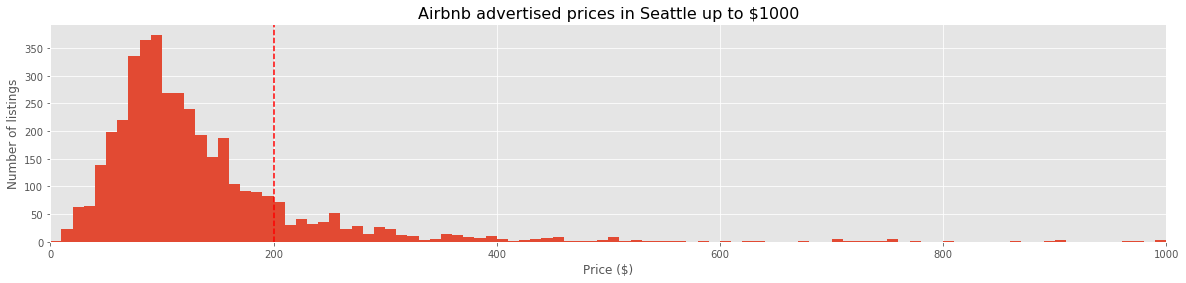

In [73]:
# Distribution of prices from $0 to $1000
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='red', linestyle='--')
plt.title("Airbnb advertised prices in Seattle up to $1000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

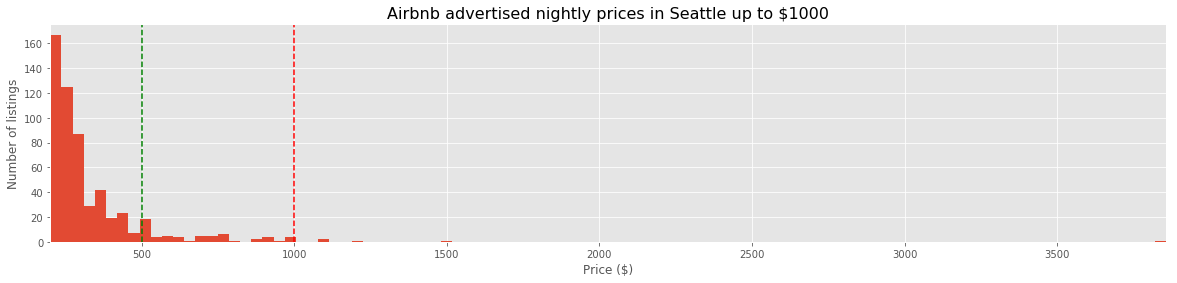

In [74]:
# Distribution of prices from $200 upwards
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(200, max(df.price)))
plt.margins(x=0)
plt.axvline(500, color='green', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in Seattle up to $1000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [75]:
# Replacing values under £10 with £10
df.loc[df.price <= 10, 'price'] = 10

# Replacing values over £1000 with £1000
df.loc[df.price >= 1000, 'price'] = 1000

`host_listings_count`

The median number of listings that the host of each listing has is 2. This means that on average (median) each listing is hosted by a host who only manages that listing. The mean is higher (127) due to some hosts managing some (very) large numbers of listings, as discussed above in the Time Series section. For example, the host with the highest number of listings has 1,435 listings under its ID. About 30% of listings are from hosts with one listing, and other part are from multi-listing hosts.

Two difficulties in discerning how many listings hosts have on average are: 

1) this number is only known on the level of the listing, so hosts with more listings are represented more frequently (e.g a host with 10 listings may be represented up to 10 times in the dataset)

2) a host's other listings may not be in Seattle, so some multi-listing hosts may appear multiple times in the dataset, and others may appear only once

In [76]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print("Highest number of listins per host:", int(round(df.host_listings_count.max())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 2
Mean number of listings per host: 127
Highest number of listins per host: 1435
31% of listings are from hosts with one listing.


`accommodates`, `bathrooms`, `bedrooms` and `beds`

The most common property setup sleeps two people in one bed in one bedroom, with one bathroom. Unsurprisingly, properties that accommodate more people achieve noticeably higher rates per night, with diminishing returns coming after about 10 people.

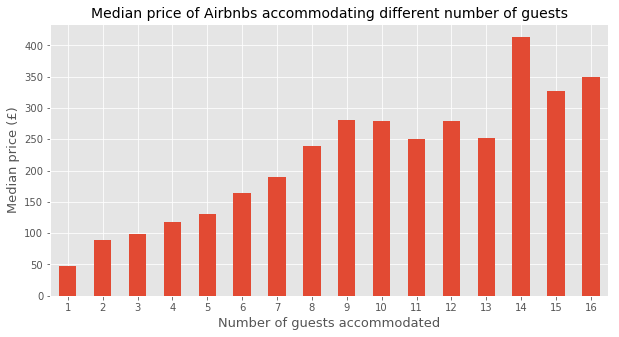

In [77]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (£)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

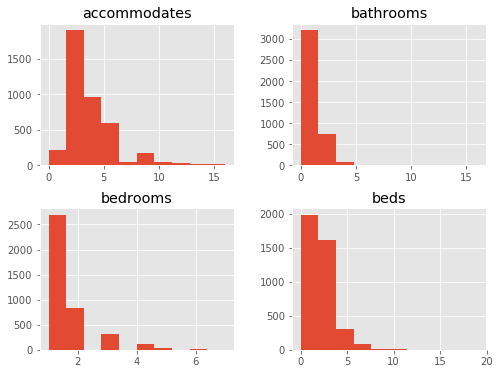

In [78]:
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

#### Categorical Features

`Neighbourhood`

In [79]:
# Renaming the neighbourhood column
df.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)

# Importing the Seattle borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpf.read_file('C:/Users/Alena/Desktop/Spring_Board/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/neighborhoods.geojson')
map_df.head()

id     city county    nhood  \
0     Seattle:Ballard:Loyal Heights  Seattle   King  Ballard   
1             Seattle:Ballard:Adams  Seattle   King  Ballard   
2  Seattle:Ballard:Whittier Heights  Seattle   King  Ballard   
3     Seattle:Ballard:West Woodland  Seattle   King  Ballard   
4       Seattle:Ballard:Sunset Hill  Seattle   King  Ballard   

             nested          area              name  \
0     Loyal Heights  2.132066e+07     Loyal Heights   
1             Adams  2.243128e+07             Adams   
2  Whittier Heights  1.419569e+07  Whittier Heights   
3     West Woodland  2.219937e+07     West Woodland   
4       Sunset Hill  2.433562e+07       Sunset Hill   

                                            geometry  
0  POLYGON ((-122.37633 47.67594, -122.37669 47.6...  
1  POLYGON ((-122.37633 47.67594, -122.37621 47.6...  
2  POLYGON ((-122.37633 47.67594, -122.37657 47.6...  
3  POLYGON ((-122.37633 47.67594, -122.37610 47.6...  
4  POLYGON ((-122.40211 47.69766, -122.40199 47.6...

In [80]:
map_df.isna().sum()

id            0
city          0
county        0
nhood        36
nested      109
area          0
name          0
geometry      0
dtype: int64

In [81]:
map_df.columns

Index(['id', 'city', 'county', 'nhood', 'nested', 'area', 'name', 'geometry'], dtype='object')

In [82]:
map_df.shape

(175, 8)

In [83]:
# Dropping the empty column
map_df.drop(['nhood', 'nested'], axis=1, inplace=True)
map_df.rename(columns={'name': 'neighbourhood'}, inplace=True)

# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(df.groupby('borough').size())
borough_df.rename(columns={0: 'number_of_listings'}, inplace=True)
borough_df['median_price'] = df.groupby('borough').price.median().values

# Joining the dataframes
borough_map_df = map_df.set_index('neighbourhood').join(borough_df)

borough_map_df.head()

id     city county  \
Adams                       Seattle:Ballard:Adams  Seattle   King   
Algona                                   Algona::   Algona   King   
Alki                    Seattle:West Seattle:Alki  Seattle   King   
Arbor Heights  Seattle:West Seattle:Arbor Heights  Seattle   King   
Atlantic            Seattle:Central Area:Atlantic  Seattle   King   

                       area  \
Adams          2.243128e+07   
Algona         3.641105e+07   
Alki           2.458347e+07   
Arbor Heights  2.619731e+07   
Atlantic       2.066499e+07   

                                                        geometry  \
Adams          POLYGON ((-122.37633 47.67594, -122.37621 47.6...   
Algona         POLYGON ((-122.23681 47.27193, -122.23681 47.2...   
Alki           POLYGON ((-122.38153 47.58952, -122.38177 47.5...   
Arbor Heights  POLYGON ((-122.37692 47.51747, -122.37598 47.5...   
Atlantic       POLYGON ((-122.31674 47.60173, -122.31225 47.6...   

               number_of_listings  median_price  
Adams                        74.0         106.0  
Algona                        NaN           NaN  
Alki                         64.0         128.5  
Arbor Heights                13.0         149.0  
Atlantic                     46.0         146.0

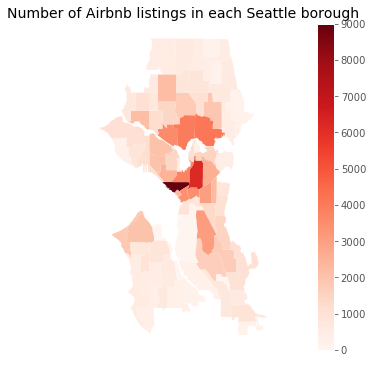

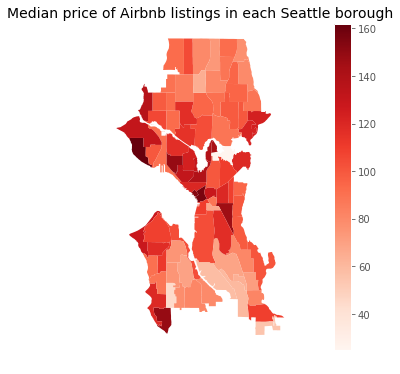

In [84]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='number_of_listings', cmap='Reds', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Seattle borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='median_price', cmap='Reds', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Seattle borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

`property_type` and `room_type` 

About 43% of properties are apartments/flats. The remainder are houses or more uncommon property types.

About 82% of listings are entire homes (i.e. you are renting the entire property on your own). Most of the remainder are private rooms (i.e. you are renting a bedroom and possibly also a bathroom, but there will be other people in the property). And 1% are shared rooms (i.e. you are sharing a room with either the property owner or other guests).

In [85]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

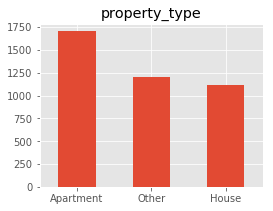

Apartment    0.423278
Other        0.299925
House        0.276797
Name: property_type, dtype: float64


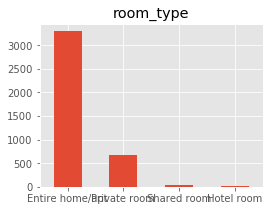

Entire home/apt    0.818702
Private room       0.166377
Shared room        0.011440
Hotel room         0.003482
Name: room_type, dtype: float64


In [86]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(df[col].value_counts(normalize=True))

`review` categories

For every review category, the majority of listings that have had a review have received a 10/10 rating for that category (or 95-100/100 overall). Ratings or 8 or below are rare. Guests seem to be most positive about communication, check-ins and accuracy. As noted previously, over a quarter of listings have not yet been reviewed.

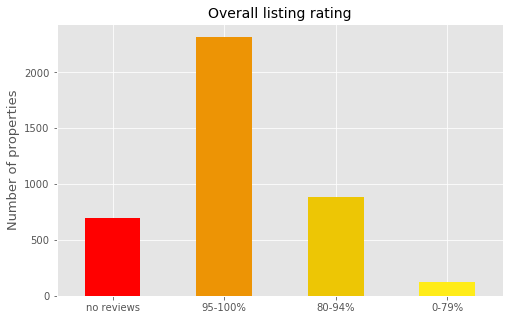

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('Overall listing rating', fontsize=14)
df['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['red', '#ed9405', '#edc605', '#ffec19' ], ax=ax)
ax.set_xticklabels(labels=['no reviews', '95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Number of properties', fontsize=13)
plt.show()

In [88]:
df['review_scores_rating'].value_counts().sort_index(ascending=False)

no reviews     697
95-100/100    2317
80-94/100      882
0-79/100       125
Name: review_scores_rating, dtype: int64

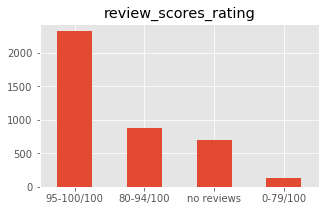

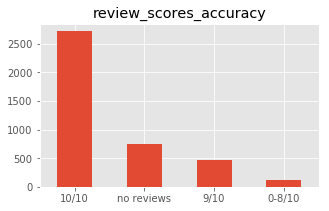

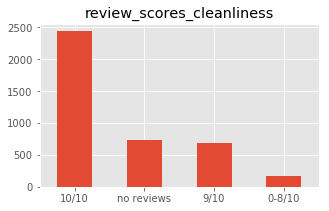

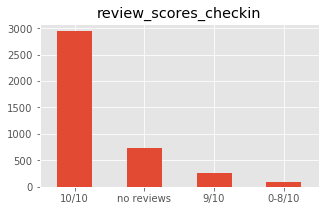

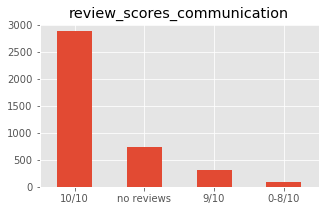

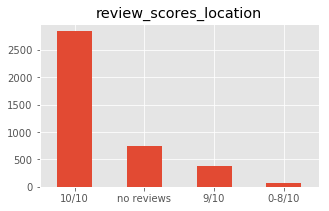

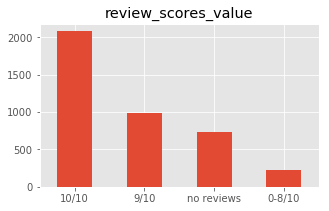

In [89]:
for col in list(df.columns[df.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

`first_review` and `last_review`

The most common time period in which currently live Airbnb listings had their first review are 4+ and 2-3 years. This means that a lot of listings on the site have been active for at least a couple of years. 

The most common category for the time since a listing received its last review is 2-8 weeks. This means that a lot of listings have been reviewed recently. The majority of these are probably what are sometimes referred to 'active' listings, because although they they have their calendards open and available to book.

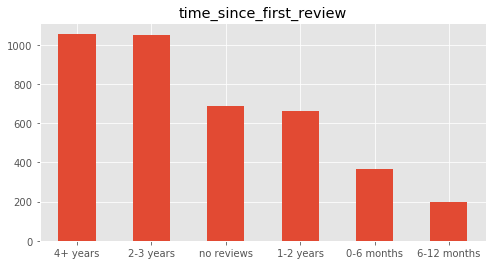

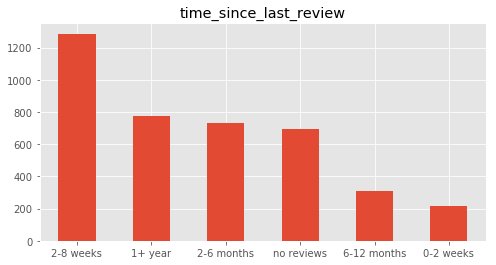

In [90]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count_plot(col)

**Venue proximity**

As part of our model, we are looking to explore proximity to certain venues as a possible price predictor. Walkability and ability to reach places maybe a deal-maker or breaker when it comes to choosing a accomodation. Proximity to certain venues, such as principal touristic attractions, restaurants, cafes and even shops could help us predict price. For this, we will use *Foursquare API* to explore the venues per neighbourhood. As discussed before, Old Town is the area which concentrates the majority of Airbnb listings. 

We now retrieve the list of venues with their locations. We will use *Foursquare API* to explore the venues around the listings, using the latitude and longitude of each neighbourhood. We dill then find out which venues are the most common and select the most common venues as points of interest (POIS) for our accessibility analysis.

In [91]:
# Define Foursquare Credentials 
# your Foursquare ID
CLIENT_ID = "23FJPWPS41YGZVLCVO41YEX3FZ4TE2JMIVHWUAHM23VIHBQE"
# your Foursquare Secret
CLIENT_SECRET = "VNJXPB1FKUPKCJFTC3IIB54RYTAALBUFDRVY0M4RP0GIBPEF"
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 23FJPWPS41YGZVLCVO41YEX3FZ4TE2JMIVHWUAHM23VIHBQE
CLIENT_SECRET:VNJXPB1FKUPKCJFTC3IIB54RYTAALBUFDRVY0M4RP0GIBPEF


In [92]:
map_df.head()

id     city county          area  \
0     Seattle:Ballard:Loyal Heights  Seattle   King  2.132066e+07   
1             Seattle:Ballard:Adams  Seattle   King  2.243128e+07   
2  Seattle:Ballard:Whittier Heights  Seattle   King  1.419569e+07   
3     Seattle:Ballard:West Woodland  Seattle   King  2.219937e+07   
4       Seattle:Ballard:Sunset Hill  Seattle   King  2.433562e+07   

      neighbourhood                                           geometry  
0     Loyal Heights  POLYGON ((-122.37633 47.67594, -122.37669 47.6...  
1             Adams  POLYGON ((-122.37633 47.67594, -122.37621 47.6...  
2  Whittier Heights  POLYGON ((-122.37633 47.67594, -122.37657 47.6...  
3     West Woodland  POLYGON ((-122.37633 47.67594, -122.37610 47.6...  
4       Sunset Hill  POLYGON ((-122.40211 47.69766, -122.40199 47.6...

We need the latitude and longitude of the neighbourhoods to retrieve the venues per neghbourhood. We can access this from the `geometry` column of our GeoDataFrame.

In [93]:
type(map_df.geometry)

geopandas.geoseries.GeoSeries

From `geometry` column in the GeoDataFrame, we can see that it returns a GeoSeries. To retrieve the venues per neighbourhood, we first extract the latitude and longitude or `x` and `y` from the point object in the GeoSeries. The following code returns `x` and `y` as separate GeoDataFrame columns within the original `map_df`. 

In [94]:
map_df["longitude"] = map_df.centroid.x
map_df["latitude"] = map_df.centroid.y

In [95]:
map_df.head()

id     city county          area  \
0     Seattle:Ballard:Loyal Heights  Seattle   King  2.132066e+07   
1             Seattle:Ballard:Adams  Seattle   King  2.243128e+07   
2  Seattle:Ballard:Whittier Heights  Seattle   King  1.419569e+07   
3     Seattle:Ballard:West Woodland  Seattle   King  2.219937e+07   
4       Seattle:Ballard:Sunset Hill  Seattle   King  2.433562e+07   

      neighbourhood                                           geometry  \
0     Loyal Heights  POLYGON ((-122.37633 47.67594, -122.37669 47.6...   
1             Adams  POLYGON ((-122.37633 47.67594, -122.37621 47.6...   
2  Whittier Heights  POLYGON ((-122.37633 47.67594, -122.37657 47.6...   
3     West Woodland  POLYGON ((-122.37633 47.67594, -122.37610 47.6...   
4       Sunset Hill  POLYGON ((-122.40211 47.69766, -122.40199 47.6...   

    longitude   latitude  
0 -122.384908  47.683276  
1 -122.386295  47.670089  
2 -122.371420  47.683296  
3 -122.368560  47.667874  
4 -122.400271  47.681312

In [96]:
# Function to loop for venues through all neighbourhoods
#url = 'https://api.foursquare.com/v2/venues/search?categoryId=50aa9e094b90af0d42d5de0d,530e33ccbcbc57f1066bbff3,530e33ccbcbc57f1066bbff9,4f2a25ac4b909258e854f55f&intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format()
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
         # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we run the above function on each neighborhood and create a new dataframe called *seattle_venues*.

In [97]:
seattle_venues = getNearbyVenues(names=map_df['neighbourhood'],
                                   latitudes=map_df['latitude'],
                                   longitudes=map_df['longitude'],
                                 radius = 500
                                  )

Loyal Heights
Adams
Whittier Heights
West Woodland
Sunset Hill
University District
East Queen Anne
West Queen Anne
Lower Queen Anne
North Queen Anne
Westlake
Eastlake
South Lake Union
Lawton Park
Briarcliff
Southeast Magnolia
Madrona
Harrison - Denny-Blaine
Minor
Leschi
Mann
Atlantic
Pike-Market
Belltown
International District
Central Business District
First Hill
Yesler Terrace
Pioneer Square
Interbay
Seaview
Gatewood
Arbor Heights
Alki
North Admiral
Fairmount Park
Genesee
Fauntleroy
North Beacon Hill
Mid-Beacon Hill
South Beacon Hill
Holly Park
Brighton
Dunlap
Rainier Beach
Rainier View
Mount Baker
Columbia City
Highland Park
North Delridge
Riverview
High Point
South Delridge
Roxhill
Seward Park
Portage Bay
Montlake
Madison Park
Broadway
Stevens
Victory Heights
Matthews Beach
Meadowbrook
Olympic Hills
Cedar Park
Haller Lake
Pinehurst
North College Park
Maple Leaf
Woodinville Heights
West Wellington
East Wellington
Tourist District
Reinwood Leota
Town Center
Lower West Ridge
North Indu

Checking the size of the returning dataframe

In [98]:
print(seattle_venues.shape)
seattle_venues.head()

(1787, 7)


Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0  Loyal Heights               47.683276              -122.384908   
1  Loyal Heights               47.683276              -122.384908   
2  Loyal Heights               47.683276              -122.384908   
3  Loyal Heights               47.683276              -122.384908   
4  Loyal Heights               47.683276              -122.384908   

                     Venue  Venue Latitude  Venue Longitude  \
0  Loyal Heights Playfield       47.683946      -122.383088   
1       Fresh Fish Company       47.686888      -122.387236   
2             Mabel Coffee       47.679650      -122.387924   
3               Cafe Munir       47.686908      -122.387996   
4          Larsen's Bakery       47.686804      -122.387524   

              Venue Category  
0               Soccer Field  
1                Fish Market  
2                Coffee Shop  
3  Middle Eastern Restaurant  
4                     Bakery

In [99]:
#!pwd
# Saving Data set
seattle_venues.to_csv('C:/Users/Alena/Desktop/Spring_Board/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/seattle_venues.csv')

In [100]:
# Read dataset
seattle_venues = pd.read_csv('C:/Users/Alena/Desktop/Spring_Board/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/seattle_venues.csv', index_col=0)

Venues returned per neighbourhood

In [101]:
seattle_venues.groupby('Neighbourhood').count()

Neighbourhood Latitude  Neighbourhood Longitude  Venue  \
Neighbourhood                                                                 
Adams                                    30                       30     30   
Algona                                    7                        7      7   
Alki                                      4                        4      4   
Arbor Heights                             2                        2      2   
Atlantic                                 10                       10     10   
...                                     ...                      ...    ...   
Windermere                                3                        3      3   
Woodinville Heights                       1                        1      1   
Woodridge                                 1                        1      1   
Yarrow Point                              3                        3      3   
Yesler Terrace                           12                       12     12   

                     Venue Latitude  Venue Longitude  Venue Category  
Neighbourhood                                                         
Adams                            30               30              30  
Algona                            7                7               7  
Alki                              4                4               4  
Arbor Heights                     2                2               2  
Atlantic                         10               10              10  
...                             ...              ...             ...  
Windermere                        3                3               3  
Woodinville Heights               1                1               1  
Woodridge                         1                1               1  
Yarrow Point                      3                3               3  
Yesler Terrace                   12               12              12  

[167 rows x 6 columns]

**Unique categories of venues**

In [102]:
print('There are {} unique categories.'.format(len(seattle_venues['Venue Category'].unique())))

There are 291 unique categories.


**Number of venues per category**

In [103]:
seattle_venues.groupby('Venue Category').count()

Neighbourhood  Neighbourhood Latitude  \
Venue Category                                              
ATM                            13                      13   
Accessories Store               2                       2   
Advertising Agency              1                       1   
African Restaurant              1                       1   
Airport                         3                       3   
...                           ...                     ...   
Wine Bar                       14                      14   
Wine Shop                       7                       7   
Winery                          8                       8   
Yoga Studio                     7                       7   
Zoo Exhibit                     4                       4   

                    Neighbourhood Longitude  Venue  Venue Latitude  \
Venue Category                                                       
ATM                                      13     13              13   
Accessories Store                         2      2               2   
Advertising Agency                        1      1               1   
African Restaurant                        1      1               1   
Airport                                   3      3               3   
...                                     ...    ...             ...   
Wine Bar                                 14     14              14   
Wine Shop                                 7      7               7   
Winery                                    8      8               8   
Yoga Studio                               7      7               7   
Zoo Exhibit                               4      4               4   

                    Venue Longitude  
Venue Category                       
ATM                              13  
Accessories Store                 2  
Advertising Agency                1  
African Restaurant                1  
Airport                           3  
...                             ...  
Wine Bar                         14  
Wine Shop                         7  
Winery                            8  
Yoga Studio                       7  
Zoo Exhibit                       4  

[291 rows x 6 columns]

**Analysis per neighbourhood**

In [104]:
# One Hot Encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix = "", prefix_sep = "")

## Add neighbourhood column back to df
seattle_onehot['Neighbourhood'] = seattle_venues['Neighbourhood']

# Move neighbourhood column to the first column
fixed_columns = [seattle_onehot.columns[-1]] + list(seattle_onehot.columns[:-1])
seattle_onehot = seattle_onehot[fixed_columns]

# display
seattle_onehot.head()

Neighbourhood  ATM  Accessories Store  Advertising Agency  \
0  Loyal Heights    0                  0                   0   
1  Loyal Heights    0                  0                   0   
2  Loyal Heights    0                  0                   0   
3  Loyal Heights    0                  0                   0   
4  Loyal Heights    0                  0                   0   

   African Restaurant  Airport  Airport Lounge  Airport Service  \
0                   0        0               0                0   
1                   0        0               0                0   
2                   0        0               0                0   
3                   0        0               0                0   
4                   0        0               0                0   

   Airport Terminal  Airport Ticket Counter  American Restaurant  \
0                 0                       0                    0   
1                 0                       0                    0   
2                 0                       0                    0   
3                 0                       0                    0   
4                 0                       0                    0   

   Amphitheater  Antique Shop  Art Gallery  Art Museum  Arts & Crafts Store  \
0             0             0            0           0                    0   
1             0             0            0           0                    0   
2             0             0            0           0                    0   
3             0             0            0           0                    0   
4             0             0            0           0                    0   

   Asian Restaurant  Assisted Living  Athletics & Sports  \
0                 0                0                   0   
1                 0                0                   0   
2                 0                0                   0   
3                 0                0                   0   
4                 0                0                   0   

   Australian Restaurant  Auto Garage  Automotive Shop  BBQ Joint  Bagel Shop  \
0                      0            0                0          0           0   
1                      0            0                0          0           0   
2                      0            0                0          0           0   
3                      0            0                0          0           0   
4                      0            0                0          0           0   

   Bakery  Bank  Bar  Baseball Field  Basketball Court  Bay  Beach  \
0       0     0    0               0                 0    0      0   
1       0     0    0               0                 0    0      0   
2       0     0    0               0                 0    0      0   
3       0     0    0               0                 0    0      0   
4       1     0    0               0                 0    0      0   

   Bed & Breakfast  Beer Bar  Beer Store  Bike Shop  Board Shop  \
0                0         0           0          0           0   
1                0         0           0          0           0   
2                0         0           0          0           0   
3                0         0           0          0           0   
4                0         0           0          0           0   

   Boarding House  ...  Supplement Shop  Surf Spot  Sushi Restaurant  \
0               0  ...                0          0                 0   
1               0  ...                0          0                 0   
2               0  ...                0          0                 0   
3               0  ...                0          0                 0   
4               0  ...                0          0                 0   

   Szechuan Restaurant  Taco Place  Tailor Shop  Tanning Salon  \
0                    0           0            0              0   
1                    0           0            0              0   
2                    0      

In [105]:
# New df dimensions
seattle_onehot.shape

(1787, 292)

**Group rows by neighbourhood and by taking the mean and the frequency of occurrence of each category**

In [106]:
seattle_grouped = seattle_onehot.groupby('Neighbourhood').mean().reset_index()
seattle_grouped

Neighbourhood  ATM  Accessories Store  Advertising Agency  \
0                  Adams  0.0                0.0                 0.0   
1                 Algona  0.0                0.0                 0.0   
2                   Alki  0.0                0.0                 0.0   
3          Arbor Heights  0.0                0.0                 0.0   
4               Atlantic  0.0                0.0                 0.0   
..                   ...  ...                ...                 ...   
162           Windermere  0.0                0.0                 0.0   
163  Woodinville Heights  0.0                0.0                 0.0   
164            Woodridge  0.0                0.0                 0.0   
165         Yarrow Point  0.0                0.0                 0.0   
166       Yesler Terrace  0.0                0.0                 0.0   

     African Restaurant  Airport  Airport Lounge  Airport Service  \
0                   0.0      0.0             0.0              0.0   
1                   0.0      0.0             0.0              0.0   
2                   0.0      0.0             0.0              0.0   
3                   0.0      0.0             0.0              0.0   
4                   0.0      0.0             0.0              0.0   
..                  ...      ...             ...              ...   
162                 0.0      0.0             0.0              0.0   
163                 0.0      0.0             0.0              0.0   
164                 0.0      0.0             0.0              0.0   
165                 0.0      0.0             0.0              0.0   
166                 0.0      0.0             0.0              0.0   

     Airport Terminal  Airport Ticket Counter  American Restaurant  \
0                 0.0                     0.0                  0.0   
1                 0.0                     0.0                  0.0   
2                 0.0                     0.0                  0.0   
3                 0.0                     0.0                  0.0   
4                 0.0                     0.0                  0.0   
..                ...                     ...                  ...   
162               0.0                     0.0                  0.0   
163               0.0                     0.0                  0.0   
164               0.0                     0.0                  0.0   
165               0.0                     0.0                  0.0   
166               0.0                     0.0                  0.0   

     Amphitheater  Antique Shop  Art Gallery  Art Museum  Arts & Crafts Store  \
0             0.0           0.0          0.0    0.000000                  0.0   
1             0.0           0.0          0.0    0.000000                  0.0   
2             0.0           0.0          0.0    0.000000                  0.0   
3             0.0           0.0          0.0    0.000000                  0.0   
4             0.0           0.0          0.0    0.000000                  0.0   
..            ...           ...          ...         ...                  ...   
162           0.0           0.0          0.0    0.000000                  0.0   
163           0.0           0.0          0.0    0.000000                  0.0   
164           0.0           0.0          0.0    0.000000                  0.0   
165           0.0           0.0          0.0    0.000000                  0.0   
166           0.0           0.0          0.0    0.083333                  0.0   

     Asian Restaurant  Assisted Living  Athletics & Sports  \
0                 0.0              0.0                 0.0   
1                 0.0              0.0                 0.0   
2                 0.0              0.0                 0.0   
3                 0.0              0.0                 0.0   
4                 0.0              0.0                 0.0   
..                ...              ...                 ...   
162               0.0              0.0                 0.0   
163    

**Get each neighbourhood along with its top 5 most common venues**

In [107]:
num_top_venues = 5

for hood in seattle_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = seattle_grouped[seattle_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adams----
             venue  freq
0   Ice Cream Shop  0.10
1     Dessert Shop  0.07
2     Burger Joint  0.07
3  Thai Restaurant  0.07
4           Bakery  0.07


----Algona----
               venue  freq
0       Home Service  0.29
1     Clothing Store  0.14
2  Convenience Store  0.14
3                Bar  0.14
4               Food  0.14


----Alki----
            venue  freq
0            Park  0.25
1  Boarding House  0.25
2           Trail  0.25
3  Scenic Lookout  0.25
4    Optical Shop  0.00


----Arbor Heights----
               venue  freq
0           Boutique   0.5
1                Spa   0.5
2                ATM   0.0
3       Optical Shop   0.0
4  Outdoor Sculpture   0.0


----Atlantic----
         venue  freq
0  Bus Station   0.2
1         Park   0.1
2        Field   0.1
3        Trail   0.1
4       Tunnel   0.1


----Auburn----
                    venue  freq
0  Thrift / Vintage Store  0.25
1      Italian Restaurant  0.25
2           Train Station  0.25
3                Pharm

4                Lake  0.12


----Harrison - Denny-Blaine----
           venue  freq
0           Café  0.13
1    Pizza Place  0.07
2    Gas Station  0.07
3         Bakery  0.07
4  Shopping Mall  0.07


----High Point----
                     venue  freq
0               Playground  0.50
1             Home Service  0.25
2                     Park  0.25
3  New American Restaurant  0.00
4             Optical Shop  0.00


----Highland Park----
                venue  freq
0          Playground  0.25
1                 Gym  0.12
2       Grocery Store  0.12
3      Baseball Field  0.12
4  Child Care Service  0.12


----Highlands----
               venue  freq
0               Park  0.50
1  Accessories Store  0.17
2      Boat or Ferry  0.17
3         Public Art  0.17
4        Karaoke Bar  0.00


----Holly Park----
                       venue  freq
0         Chinese Restaurant  0.13
1            Thai Restaurant  0.13
2                 Playground  0.13
3                       Café  0.07
4  Cajun / 

4  Fast Food Restaurant  0.05


----North Queen Anne----
             venue  freq
0              ATM  0.12
1   Sandwich Place  0.12
2  Harbor / Marina  0.12
3     Soccer Field  0.12
4          Theater  0.12


----North Rose Hill----
                        venue  freq
0                  Playground   0.2
1                      Garden   0.2
2                    Bus Stop   0.2
3                        Park   0.2
4  Construction & Landscaping   0.2


----Northeast Bellevue----
            venue  freq
0  Rental Service  0.25
1        Bus Stop  0.25
2  Baseball Field  0.25
3            Park  0.25
4             ATM  0.00


----Northwest Bellevue----
            venue  freq
0      Food Truck  0.50
1  Farmers Market  0.17
2           Trail  0.17
3          Bakery  0.17
4             ATM  0.00


----Olympic Hills----
                  venue  freq
0                   Gym  0.33
1            Food Truck  0.33
2                  Pool  0.33
3          Optical Shop  0.00
4  Outdoor Supply Store  0.00



                   venue  freq
0  Performing Arts Venue  0.33
1                Dog Run  0.33
2           Gourmet Shop  0.33
3                    ATM  0.00
4        Organic Grocery  0.00


----Victory Heights----
                  venue  freq
0  Marijuana Dispensary  0.11
1           Pizza Place  0.11
2           Music Store  0.11
3              Pharmacy  0.11
4           Coffee Shop  0.11


----View Ridge----
                  venue  freq
0                  Park   1.0
1         Radio Station   0.0
2  Outdoor Supply Store   0.0
3     Outdoor Sculpture   0.0
4     Other Repair Shop   0.0


----Wallingford----
                 venue  freq
0          Coffee Shop  0.10
1     Asian Restaurant  0.07
2       Ice Cream Shop  0.07
3  Japanese Restaurant  0.07
4      Thai Restaurant  0.03


----Wedge----
                  venue  freq
0            Skate Park  0.25
1    Athletics & Sports  0.25
2        Rental Service  0.25
3        Baseball Field  0.25
4  Other Great Outdoors  0.00


----Wedgwood-

**Put that in pandas data frame**

In [108]:
# Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [109]:
import numpy as np

# New dataframe ordered
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = seattle_grouped['Neighbourhood']

for ind in np.arange(seattle_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], 
                                                                          num_top_venues)

neighbourhoods_venues_sorted.head()

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0          Adams        Ice Cream Shop          Dessert Shop   
1         Algona          Home Service        Clothing Store   
2           Alki                  Park        Boarding House   
3  Arbor Heights              Boutique                   Spa   
4       Atlantic           Bus Station                  Park   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0          Burger Joint       Thai Restaurant                Bakery  
1     Convenience Store                   Bar                  Food  
2                 Trail        Scenic Lookout          Optical Shop  
3                   ATM          Optical Shop     Outdoor Sculpture  
4                 Field                 Trail                Tunnel

**Let's look at how many categories are on the 1st most common venue.**

In [110]:
print('There are {} unique categories.'.format(len(neighbourhoods_venues_sorted['1st Most Common Venue'].unique())))

There are 76 unique categories.


In [111]:
neighbourhoods_venues_sorted.groupby('1st Most Common Venue').count()

Neighbourhood  2nd Most Common Venue  \
1st Most Common Venue                                                
ATM                                       3                      3   
Advertising Agency                        1                      1   
Airport                                   1                      1   
Art Gallery                               1                      1   
Asian Restaurant                          1                      1   
Athletics & Sports                        2                      2   
Auto Garage                               1                      1   
BBQ Joint                                 2                      2   
Bakery                                    2                      2   
Bar                                       1                      1   
Baseball Field                            2                      2   
Boutique                                  1                      1   
Bowling Alley                             1                      1   
Brewery                                   3                      3   
Burger Joint                              1                      1   
Bus Station                               2                      2   
Bus Stop                                  5                      5   
Business Service                          1                      1   
Café                                      1                      1   
Candy Store                               1                      1   
Chinese Restaurant                        1                      1   
Cocktail Bar                              1                      1   
Coffee Shop                              15                     15   
Concert Hall                              1                      1   
Construction & Landscaping                4                      4   
Convenience Store                         3                      3   
Deli / Bodega                             1                      1   
Donut Shop                                1                      1   
Ethiopian Restaurant                      1                      1   
Food                                      2                      2   
Food Truck                                2                      2   
Football Stadium                          2                      2   
French Restaurant                         1                      1   
Furniture / Home Store                    1                      1   
Garden                                    2                      2   
Gas Station                               1                      1   
Gift Shop                                 1                      1   
Grocery Store                             1                      1   
Gym                                       2                      2   
Harbor / Marina                           2                      2   
Home Service                              6                      6   
Hotel                                     1                      1   
Ice Cream Shop                            1                      1   
Italian Restaurant                        1                      1   
Jewelry Store                             1                      1   
Kerala Restaurant                         1                      1   
Locksmith                                 1                      1   
Marijuana Dispensary                      4                      4   
Mexican Restaurant                        3                      3   
Museum                                    1                      1   
Music Venue                               1                      1   
Park                                     23                     23   
Performing Arts Venue                     1                      1   
Pharmacy                                  1                      1   
Pizza Place                               2                      2   
Playground                              

From above, we observe that the most common venues across the dataset are Hotel, Pub, Grocery Store, Supermarket, Cafe, Coffee Shop, with Bar, Bus Stop and Indian Restaurant coming behind. It is clear that different restaurant venues are in subcategories which makes them less common than if they were aggregated. Thus, for the purpose accounting for the venues that may have the most impact on price, we will limit the venues to the most common categories.  It is unlikely that having a hotel nearby will affect price, as Airbnb listings are considered to be on a different category of short-term rental, due to the different benefits they provide versus hotels. Thus, that category of venues will not be considered.

### 4. Walkability to nearest venues

We will use this information on venues to select Points of Interest for which we will graph and measure access to each one. For this purpose, we will use [OSMnx](https://geoffboeing.com/2016/11/osmnx-python-street-networks/) and [Pandana](https://udst.github.io/pandana/introduction.html#contributing-to-pandana) libraries.

Pandana is a handy graph library that allows for Pandas data frames to be passed through into a network graph that maps graph-level analyses to underlying C operations. All of this is to say, it's much faster than traditional Python-based graphs, such as NetworkX.

In certain situations, such as the performance of accessibility analyses, this makes in-memory performance and iterative development based on this library possible, as opposed to what would be a cumbersome development process with tools that fail to leverage the same degree of C-level operations utilization.

#### Points of interest (POIs) and network data from OSM
We now get the points of interest. For our case, we already have the POIS retrieved using the Foursquare API. As we found out in the previous section, Pubs, Restaurants, Cafes and Supermarkets/Grocery Stores are our POIS.

In [112]:
# same with Seattle venues
seattle_venues['Venue Category'].value_counts()
#seattle_venues.head()

Coffee Shop                   117
Park                           80
Pizza Place                    48
Playground                     35
Sandwich Place                 32
                             ... 
Tourist Information Center      1
Storage Facility                1
Liquor Store                    1
Creperie                        1
Assisted Living                 1
Name: Venue Category, Length: 291, dtype: int64

In [113]:
#Get just Pub, Cafe, Bar And Restaurant
start_time = time.time()

# Points of interest already exists. Load from seattle_venues
df_pois = seattle_venues.copy()
terms = ['Grocery Store', 'Bar', 'Pub', 'Restaurant', 'Café']
df_pois = df_pois[df_pois['Venue Category'].str.contains('|'.join(terms))]
df_pois.to_csv('C:/Users/Alena/Desktop/Spring_Board/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/foursquare_amenities.csv', index=id, header=True)
method = 'loaded from CSV'

print('{:,} POIs {} in {:,.2f} seconds'.format(len(df_pois), method, time.time()-start_time))
df_pois.head()

470 POIs loaded from CSV in 0.02 seconds


Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
3   Loyal Heights               47.683276              -122.384908   
14          Adams               47.670089              -122.386295   
15          Adams               47.670089              -122.386295   
16          Adams               47.670089              -122.386295   
25          Adams               47.670089              -122.386295   

                 Venue  Venue Latitude  Venue Longitude  \
3           Cafe Munir       47.686908      -122.387996   
14         Pestle Rock       47.668532      -122.386615   
15  La Carta De Oaxaca       47.668169      -122.385767   
16                Ocho       47.668589      -122.387446   
25                Vain       47.667575      -122.384756   

               Venue Category  
3   Middle Eastern Restaurant  
14            Thai Restaurant  
15         Mexican Restaurant  
16           Tapas Restaurant  
25         Salon / Barbershop

In [114]:
# Making sure each variable's type makes sense
df_pois.dtypes

Neighbourhood               object
Neighbourhood Latitude     float64
Neighbourhood Longitude    float64
Venue                       object
Venue Latitude             float64
Venue Longitude            float64
Venue Category              object
dtype: object

In [115]:
# how many points of interest of each type of amenity did we retrieve?
df_pois['Venue Category'].value_counts()

Mexican Restaurant                 31
Vietnamese Restaurant              29
Bar                                28
Grocery Store                      27
Thai Restaurant                    25
Italian Restaurant                 24
Café                               23
American Restaurant                23
Chinese Restaurant                 21
Japanese Restaurant                17
Asian Restaurant                   16
Sushi Restaurant                   15
Cocktail Bar                       14
Wine Bar                           14
Restaurant                         12
Fast Food Restaurant               11
Salon / Barbershop                 11
Pub                                10
Indian Restaurant                   9
Ethiopian Restaurant                8
Seafood Restaurant                  8
Mediterranean Restaurant            8
New American Restaurant             7
Greek Restaurant                    6
Sports Bar                          6
Juice Bar                           6
Middle Easte

Restaurants are divided in sub-categories. Let's just put them together.

In [116]:
# Put all restaurant, bar and pub venues together under same name
df_pois.loc[df_pois['Venue Category'].str.contains('Restaurant', case=False), 'Venue Category'] = 'Restaurant'
df_pois.loc[df_pois['Venue Category'].str.contains('Bar', case=False), 'Venue Category'] = 'Bar'
df_pois.loc[df_pois['Venue Category'].str.contains('Pub', case=False), 'Venue Category'] = 'Pub'
df_pois['Venue Category'].value_counts()

Restaurant       318
Bar               90
Grocery Store     27
Café              23
Pub               12
Name: Venue Category, dtype: int64

Next we get the street network data from the OSM API.

In [117]:
# configure filenames to save/load network datasets
# Seattle's bounding box found here: https://boundingbox.klokantech.com/
bbox = [47.481002, -122.459696, 47.734136, -122.224433] 
bbox_string = '_'.join([str(x) for x in bbox])
net_filename = 'C:/Users/Alena/Desktop/Spring_Board/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/network_{}.h5'.format(bbox_string)

In [118]:
start_time = time.time()

# query the OSM API for the street network within the specified bounding box
network = osm.pdna_network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])
method = 'downloaded from OSM'

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](47.48100200,-122.45969600,47.73413600,-122.22443300);>;);out;'}"
Downloaded 48,815.9KB from www.overpass-api.de in 9.69 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 12.30 seconds
Returning OSM data with 285,153 nodes and 84,477 ways...
Edge node pairs completed. Took 204.04 seconds
Returning processed graph with 114,588 nodes and 164,480 edges...
Completed OSM data download and Pandana node and edge table creation in 229.01 seconds


In [119]:
print(type(network))

<class 'pandana.network.Network'>


In [120]:
# identify nodes that are connected to fewer than some threshold of other nodes within a given distance
lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')

# remove low-connectivity nodes and save to h5
network.save_hdf5('mynetwork.h5',rm_nodes=lcn)

In [121]:
print('Network with {:,} nodes {} in {:,.2f} secs'.format(len(network.node_ids), method, time.time()-start_time))

Network with 114,588 nodes downloaded from OSM in 308.00 secs


When saving a Network to HDF5 it’s possible to exclude certain nodes. This can be useful when refining a network so that it includes only validated nodes. As an example, you can use the `low_connectivity_nodes()` method to identify nodes that may not be connected to the larger network, then exclude those nodes when saving to HDF5. In the current design of Pandana it’s not possible to modify a Network in place. Instead, save the network (with low-connectivity nodes removed) to HDF5 and then load it from that file by re-starting the notebook.

#### Calculate accessibility to any amenity we retrieved

This is where conducting geographical analysis in Python shows its power, as opposed to sitting in front of a GIS package. Pandana is built for speed. First, we'll pass it a maximum search distance. This allows a key step that speeds up future enquiries: Pandana will build a condensed representation of the network (implemented in C++), allowing rapid calculations within a defined radius of each node. We then, build a table of distances to the nearest 5 points of interest from a couple of intersections.
When this is finished, accessibility analyses for different selected amenities can be done in under a second. (Behind the scenes, two algorithms make this possible: [contraction hierarchies](https://www.mjt.me.uk/posts/contraction-hierarchies/) and [kd-trees](https://www.geeksforgeeks.org/k-dimensional-tree/).

This section of the notebook is heavily based on Professor Geoff Boeing's [Pandana demo notebook](https://nbviewer.jupyter.org/github/gboeing/urban-data-science/blob/master/20-Accessibility-Walkability/pandana-accessibility-demo-full.ipynb).

In [122]:
# configure search at a max distance of 1 km for up to the 10 nearest points-of-interest
distance = 1000
num_pois = 10
num_categories = len(df_pois['Venue']) + 1 #one for each amenity, plus one extra for all of them combined

In [123]:
## precomputes the range queries (the reachable nodes within this maximum distance)
# so, as long as you use a smaller distance, cached results will be used
network.precompute(distance + 1)

In [124]:
# initialize the underlying C++ points-of-interest engine
network.init_pois(num_categories=num_categories, max_dist=distance, max_pois=num_pois)

In [125]:
# initialize a category for all amenities with the locations specified by the lon and lat columns
# with seattle_Venues subset df_pois
network.set_pois(category='all', x_col = df_pois['Venue Longitude'], y_col = df_pois['Venue Latitude'])

Reading parameters from init_pois()
Reading parameters from init_pois()


In [126]:
# searches for the n-nearest amenities (of all types) to each node in the network
all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# it returns a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the n POIs
print('{:,} nodes'.format(len(all_access)))
all_access.head() # Distance in meters to ten nearest amenities

114,588 nodes


1            2            3            4            5   \
id                                                                          
29449863    81.962997   487.006012   548.526001   548.526001   591.034973   
29463657   183.197006   600.822021   657.460999   657.460999   704.851013   
29464223    74.128998   491.753998   548.393005   548.393005   595.783020   
29464594   506.587006   914.518005   976.038025   976.038025  1000.000000   
29464742  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   

                   6       7       8       9       10  
id                                                     
29449863   591.034973  1000.0  1000.0  1000.0  1000.0  
29463657   704.851013  1000.0  1000.0  1000.0  1000.0  
29464223   595.783020  1000.0  1000.0  1000.0  1000.0  
29464594  1000.000000  1000.0  1000.0  1000.0  1000.0  
29464742  1000.000000  1000.0  1000.0  1000.0  1000.0

#### Produce Accessibility maps

In [127]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'Reds', 
               'edgecolor':'none'}

# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'Reds'

# keyword arguments to pass for hex bin plots
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'Reds', 
                   'edgecolor':'none'}

# keyword arguments to pass to make the colorbar
cbar_kwargs = {}

# keyword arguments to pass to basemap
bmap_kwargs = {}

# color to make the background of the axis
bgcolor = 'k'

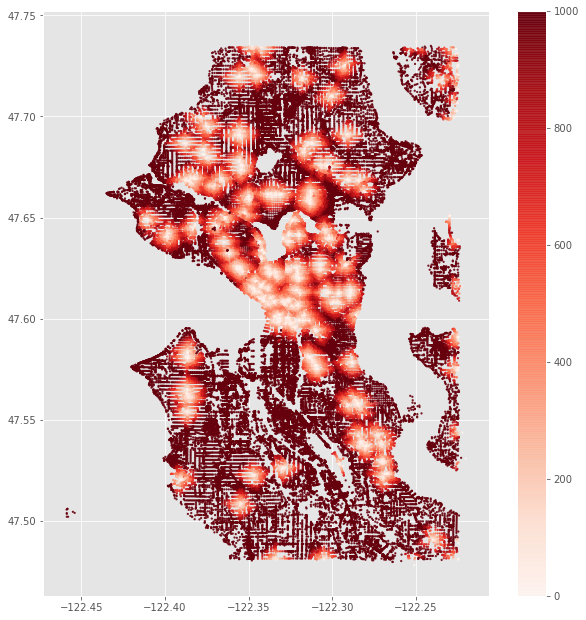

In [128]:
# distance to the nearest amenity of any type
n = 1
fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                              cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest amenity around Seattle', fontsize=15)
fig.savefig('C:/Users/Alena/Desktop/Spring_Board/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/accessibility-seattle.png', dpi=200, bbox_inches='tight')

As seen above, there are some zones where people have to walk more than 500 meters to reach the nearest amenity, whereas in Seattle's Old Town has walking distances of less than 100 meters on average.

The map shows the walking distance in meters from each network node to the nearest restaurant, bar, cafe, pub and Grocery shop. But, a better indicator of accessibility might be having access to a large number of amenities. So instead of the nearest, we plot accessibility to the fifth-nearest amenity:

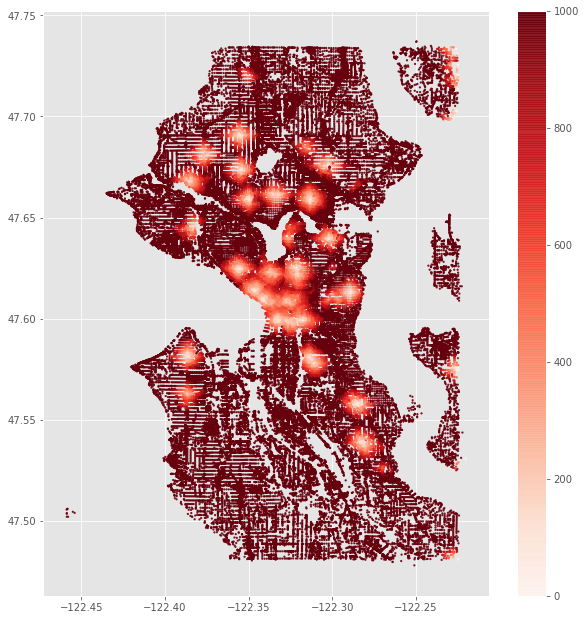

In [129]:
# distance to the 5th nearest amenity of any type
n = 5
fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                              cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to 5th nearest amenity around Seattle', fontsize=15)
fig.savefig('C:/Users/Alena/Desktop/Spring_Board/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/accessibility-nearest5th-Seattle.png', dpi=200, bbox_inches='tight')

This time, is even more noticeable that Old Town and the city center area of Seattle is more accessible. 

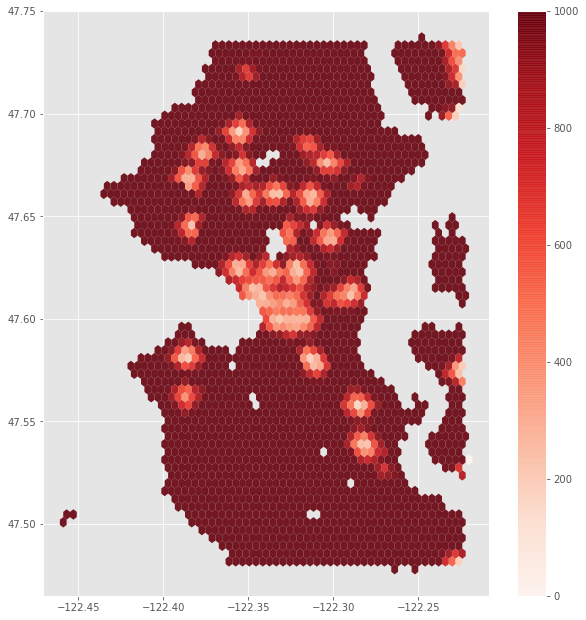

In [130]:
# distance to the 5th nearest amenity of any type, as hexbins
n=5
fig, ax = network.plot(all_access[n], bbox=bbox, plot_type='hexbin', plot_kwargs=hex_plot_kwargs, 
                             fig_kwargs=fig_kwargs,  cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest amenity around Seattle', fontsize=15)
fig.savefig('C:/Users/Alena/Desktop/Spring_Board/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/accessibility-hexbins-seattle.png', dpi=200, bbox_inches='tight')

Accessibility scores can quickly be constructed to answer a given question: whether it’s access to essential services, or walkable neighborhoods that appeal to young workers. For our purposes, access to restaurants, shops, cafes, bars and pubs are taken as essential for Airbnb users. So we are weighting all amenities equally and using distance to the fifth nearest amenity as a compound measure of accessibility. This gives a clearer picture of which neighborhoods are most walkable, compared with plotting just the distance to the single nearest venue/amenity.

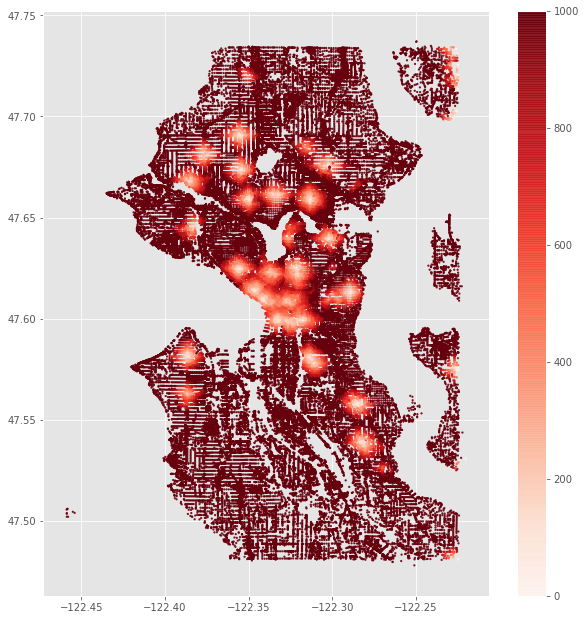

In [131]:
# distance to the 5th nearest amenity of any type
n = 5
fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                              cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to 5th nearest amenity around Seattle', fontsize=15)
fig.savefig('C:/Users/Alena/Desktop/Spring_Board/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/accessibility-nearest5th-Seattle.png', dpi=200, bbox_inches='tight')

#### Setting distance to the fifth nearest amenity as a compound measure of accessibility

In [132]:
# retreive the 5th nearest amenities (of all types) to each node in the network
num_pois = 5
N_nearest_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# returned a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the 5 POIs
print('{:,} nodes'.format(len(N_nearest_access)))

Access_Score = pd.DataFrame(N_nearest_access[5])
Access_Score.head()

114,588 nodes


5
id                   
29449863   591.034973
29463657   704.851013
29464223   595.783020
29464594  1000.000000
29464742  1000.000000

#### Network aggregation

Here, we combine `Score`, our compound measure of accessibility (network distance from the node to the 5th nearest POIs) with the POIs dataset `df_pois`.

In [133]:
# We name our measure 'Score'
Access = Access_Score.rename(columns={5:'Score'})
Access.head()
Access.dtypes

Score    float64
dtype: object

Get the nearest `node_id` for each POI, based on its lat-lon

In [134]:
df_pois['node_ids'] = network.get_node_ids(df_pois['Venue Longitude'], df_pois['Venue Latitude'])
df_pois.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
3   Loyal Heights               47.683276              -122.384908   
14          Adams               47.670089              -122.386295   
15          Adams               47.670089              -122.386295   
16          Adams               47.670089              -122.386295   
25          Adams               47.670089              -122.386295   

                 Venue  Venue Latitude  Venue Longitude Venue Category  \
3           Cafe Munir       47.686908      -122.387996     Restaurant   
14         Pestle Rock       47.668532      -122.386615     Restaurant   
15  La Carta De Oaxaca       47.668169      -122.385767     Restaurant   
16                Ocho       47.668589      -122.387446     Restaurant   
25                Vain       47.667575      -122.384756            Bar   

      node_ids  
3   7300817240  
14  6235394298  
15  4520154142  
16  6209254125  
25  6292664178

In [135]:
#pois_sub.reset_index(level=0, inplace=True) # convert index into column
Access.reset_index(level=0, inplace=True)

In [136]:
# Set both columns to have the same names
Access = Access.rename(columns={'id':'node_ids'})
Access.head()

node_ids        Score
0  29449863   591.034973
1  29463657   704.851013
2  29464223   595.783020
3  29464594  1000.000000
4  29464742  1000.000000

In [137]:
# Merging by node_ids
merged = pd.merge(df_pois, Access, on='node_ids')

In [138]:
# Checking column types make sense
merged.dtypes

Neighbourhood               object
Neighbourhood Latitude     float64
Neighbourhood Longitude    float64
Venue                       object
Venue Latitude             float64
Venue Longitude            float64
Venue Category              object
node_ids                     int64
Score                      float64
dtype: object

In [139]:
merged.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0  Loyal Heights               47.683276              -122.384908   
1          Adams               47.670089              -122.386295   
2          Adams               47.670089              -122.386295   
3          Adams               47.670089              -122.386295   
4          Adams               47.670089              -122.386295   

                Venue  Venue Latitude  Venue Longitude Venue Category  \
0          Cafe Munir       47.686908      -122.387996     Restaurant   
1         Pestle Rock       47.668532      -122.386615     Restaurant   
2  La Carta De Oaxaca       47.668169      -122.385767     Restaurant   
3      Skål Beer Hall       47.668047      -122.385817            Bar   
4                Ocho       47.668589      -122.387446     Restaurant   

     node_ids        Score  
0  7300817240  1000.000000  
1  6235394298   165.895004  
2  4520154142   149.371994  
3  4520154142   149.371994  
4  6209254125   251.501007

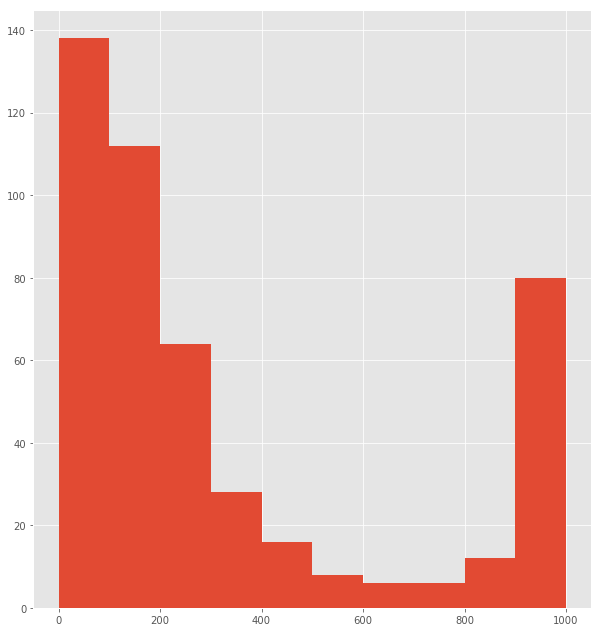

In [140]:
merged['Score'].hist(figsize=(10,11))

In [141]:
# Setting both columns have the same name for merging
df = df.rename(columns={'borough': 'Neighbourhood'})

In [142]:
# Merging by neighbourhoods
df_merged = pd.merge(merged, df, on='Neighbourhood')

In [143]:
# Save cleaned for modelling
df_merged.to_csv('C:/Users/Alena/Desktop/Spring_Board/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/listings_model.csv', index=id, header=True)

### 6. Preparing data for modelling

#### Dropping columns and assessing multi-collinearity

Categorical variables will now be one-hot encoded:

The accessibility score `Score`(distance to the fifth nearest venue) is now applied to each listing, based on which neighbourhood they belong to. Thus, we no longer need the geographical data or the venue data.

In [144]:
# Open merged dataset for modelling
df_merged = pd.read_csv('C:/Users/Alena/Desktop/Spring_Board/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/Predicting-Airbnb-prices-with-machine-learning-and-location-data-gh-pages/listings_model.csv', index_col=0)
df_merged.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude       Venue  \
0  Loyal Heights               47.683276              -122.384908  Cafe Munir   
1  Loyal Heights               47.683276              -122.384908  Cafe Munir   
2  Loyal Heights               47.683276              -122.384908  Cafe Munir   
3  Loyal Heights               47.683276              -122.384908  Cafe Munir   
4  Loyal Heights               47.683276              -122.384908  Cafe Munir   

   Venue Latitude  Venue Longitude Venue Category    node_ids   Score  \
0       47.686908      -122.387996     Restaurant  7300817240  1000.0   
1       47.686908      -122.387996     Restaurant  7300817240  1000.0   
2       47.686908      -122.387996     Restaurant  7300817240  1000.0   
3       47.686908      -122.387996     Restaurant  7300817240  1000.0   
4       47.686908      -122.387996     Restaurant  7300817240  1000.0   

   host_response_time host_response_rate  host_is_superhost  \
0  within a few hours               100%                0.0   
1  within a few hours               100%                0.0   
2  within a few hours               100%                0.0   
3      within an hour               100%                1.0   
4      within an hour               100%                1.0   

   host_listings_count  host_identity_verified neighbourhood_group_cleansed  \
0                  1.0                     0.0                      Ballard   
1                  1.0                     1.0                      Ballard   
2                  1.0                     0.0                      Ballard   
3                  2.0                     1.0                      Ballard   
4                  2.0                     1.0                      Ballard   

  property_type        room_type  accommodates  bathrooms  bedrooms  beds  \
0     Apartment  Entire home/apt             3        1.0       1.0   1.0   
1         House  Entire home/apt             4        2.0       3.0   3.0   
2         House  Entire home/apt             2        1.0       1.0   1.0   
3     Apartment  Entire home/apt             4        1.0       1.0   2.0   
4     Apartment  Entire home/apt             4        1.0       4.0   4.0   

   price  minimum_nights  maximum_nights  availability_365  number_of_reviews  \
0     67              30              60               358                 97   
1    125               6            1125               105                 13   
2     65               1              10                65                295   
3     90               1              28                 0                391   
4    150               2             365               258                111   

  review_scores_rating review_scores_accuracy review_scores_cleanliness  \
0            80-94/100                  10/10                    0-8/10   
1           95-100/100                  10/10                     10/10   
2            80-94/100                  10/10                      9/10   
3           95-100/100                  10/10                     10/10   
4           95-100/100                  10/10                     10/10   

  review_scores_checkin review_scores_communication review_scores_location  \
0                 10/10                       10/10                  10/10   
1                 10/10                       10/10                  10/10   
2                 10/10                       10/10                  10/10   
3                 10/10                       10/10                  10/10   
4                 10/10                       10/10                  10/10   

  review_scores_value  instant_bookable  host_days_active  air_conditioning  \
0               10/10                 0            4007.0               0.0   
1               10/10                 0            2877.0               1.0   
2               10/10                 0            3584.0               0.0   
3               10/10                

In [145]:
# Dropping variables no longer needed
df_merged.drop(['Neighbourhood Longitude', 'Venue Latitude', 'Venue Longitude','Neighbourhood Latitude',
               'Venue Category', 'node_ids', 'Venue'], axis=1, inplace=True)

We get dummies for our categorical variables to get the dataset ready for multicollinearity analysis. 

In [146]:
transformed_df = pd.get_dummies(df_merged)
transformed_df.head()

Score  host_is_superhost  host_listings_count  host_identity_verified  \
0  1000.0                0.0                  1.0                     0.0   
1  1000.0                0.0                  1.0                     1.0   
2  1000.0                0.0                  1.0                     0.0   
3  1000.0                1.0                  2.0                     1.0   
4  1000.0                1.0                  2.0                     1.0   

   accommodates  bathrooms  bedrooms  beds  price  minimum_nights  \
0             3        1.0       1.0   1.0     67              30   
1             4        2.0       3.0   3.0    125               6   
2             2        1.0       1.0   1.0     65               1   
3             4        1.0       1.0   2.0     90               1   
4             4        1.0       4.0   4.0    150               2   

   maximum_nights  availability_365  number_of_reviews  instant_bookable  \
0              60               358                 97                 0   
1            1125               105                 13                 0   
2              10                65                295                 0   
3              28                 0                391                 1   
4             365               258                111                 1   

   host_days_active  air_conditioning  bbq  balcony  bed_linen   tv  \
0            4007.0               0.0  0.0      0.0        1.0  0.0   
1            2877.0               1.0  1.0      1.0        1.0  1.0   
2            3584.0               0.0  0.0      0.0        1.0  1.0   
3            2731.0               0.0  1.0      1.0        1.0  1.0   
4            2775.0               1.0  0.0      1.0        1.0  1.0   

   coffee_machine  cooking_basics  white_goods  elevator  gym  child_friendly  \
0             0.0             1.0          0.0       0.0  0.0             1.0   
1             1.0             1.0          1.0       0.0  0.0             1.0   
2             1.0             0.0          0.0       0.0  0.0             0.0   
3             1.0             1.0          1.0       0.0  0.0             0.0   
4             1.0             1.0          1.0       0.0  1.0             0.0   

   parking  outdoor_space  internet  long_term_stays  private_entrance  \
0      1.0            0.0       1.0              1.0               1.0   
1      1.0            1.0       1.0              1.0               0.0   
2      1.0            1.0       1.0              0.0               1.0   
3      1.0            0.0       1.0              1.0               0.0   
4      1.0            0.0       1.0              1.0               1.0   

   Neighbourhood_Adams  Neighbourhood_Atlantic  Neighbourhood_Belltown  \
0                    0                       0                       0   
1                    0                       0                       0   
2                    0                       0                       0   
3                    0                       0                       0   
4                    0                       0                       0   

   Neighbourhood_Bitter Lake  Neighbourhood_Briarcliff  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         0   

   Neighbourhood_Brighton  ...  review_scores_rating_no reviews  \
0                       0  ...                                0   
1                       0  ...                                0   
2                       0  ...                                0   
3                       0  ...                                0   
4                       0  ...                                0   

   review_scores_accuracy_0-8/10  review_scores_accuracy_10/10  \
0                              0               

We now assess for multicollinearity of features:

In [147]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

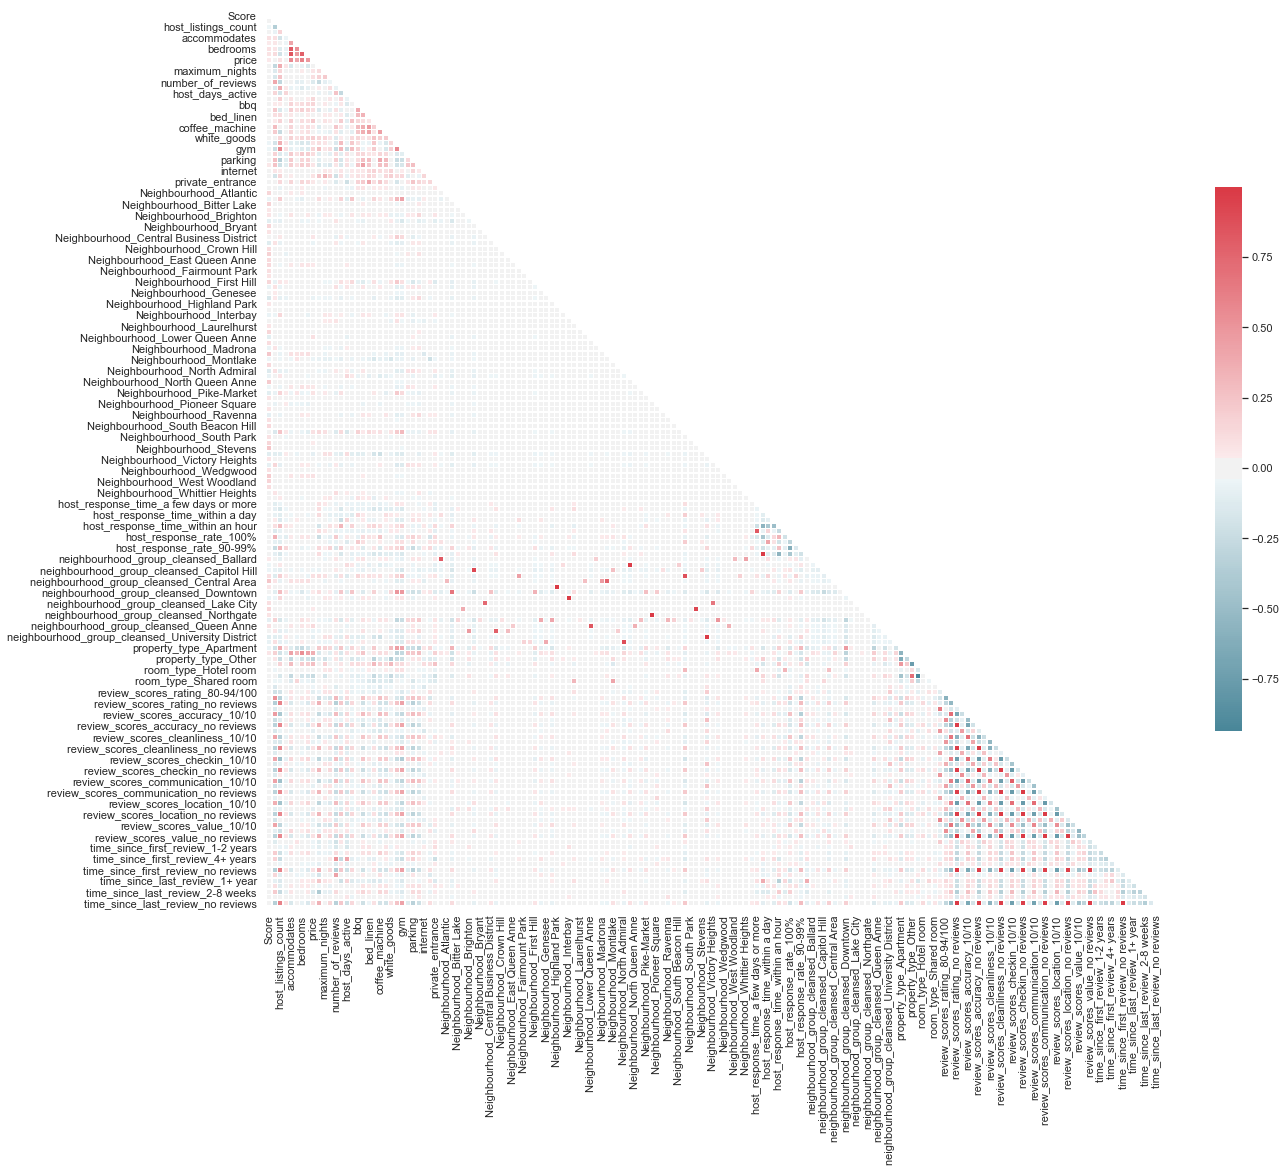

In [148]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

It doesn't look like there are any significant collinear relationships with neighbourhood variables, so these will temporarily be dropped to produce a clearer heatmap for the remaining features:

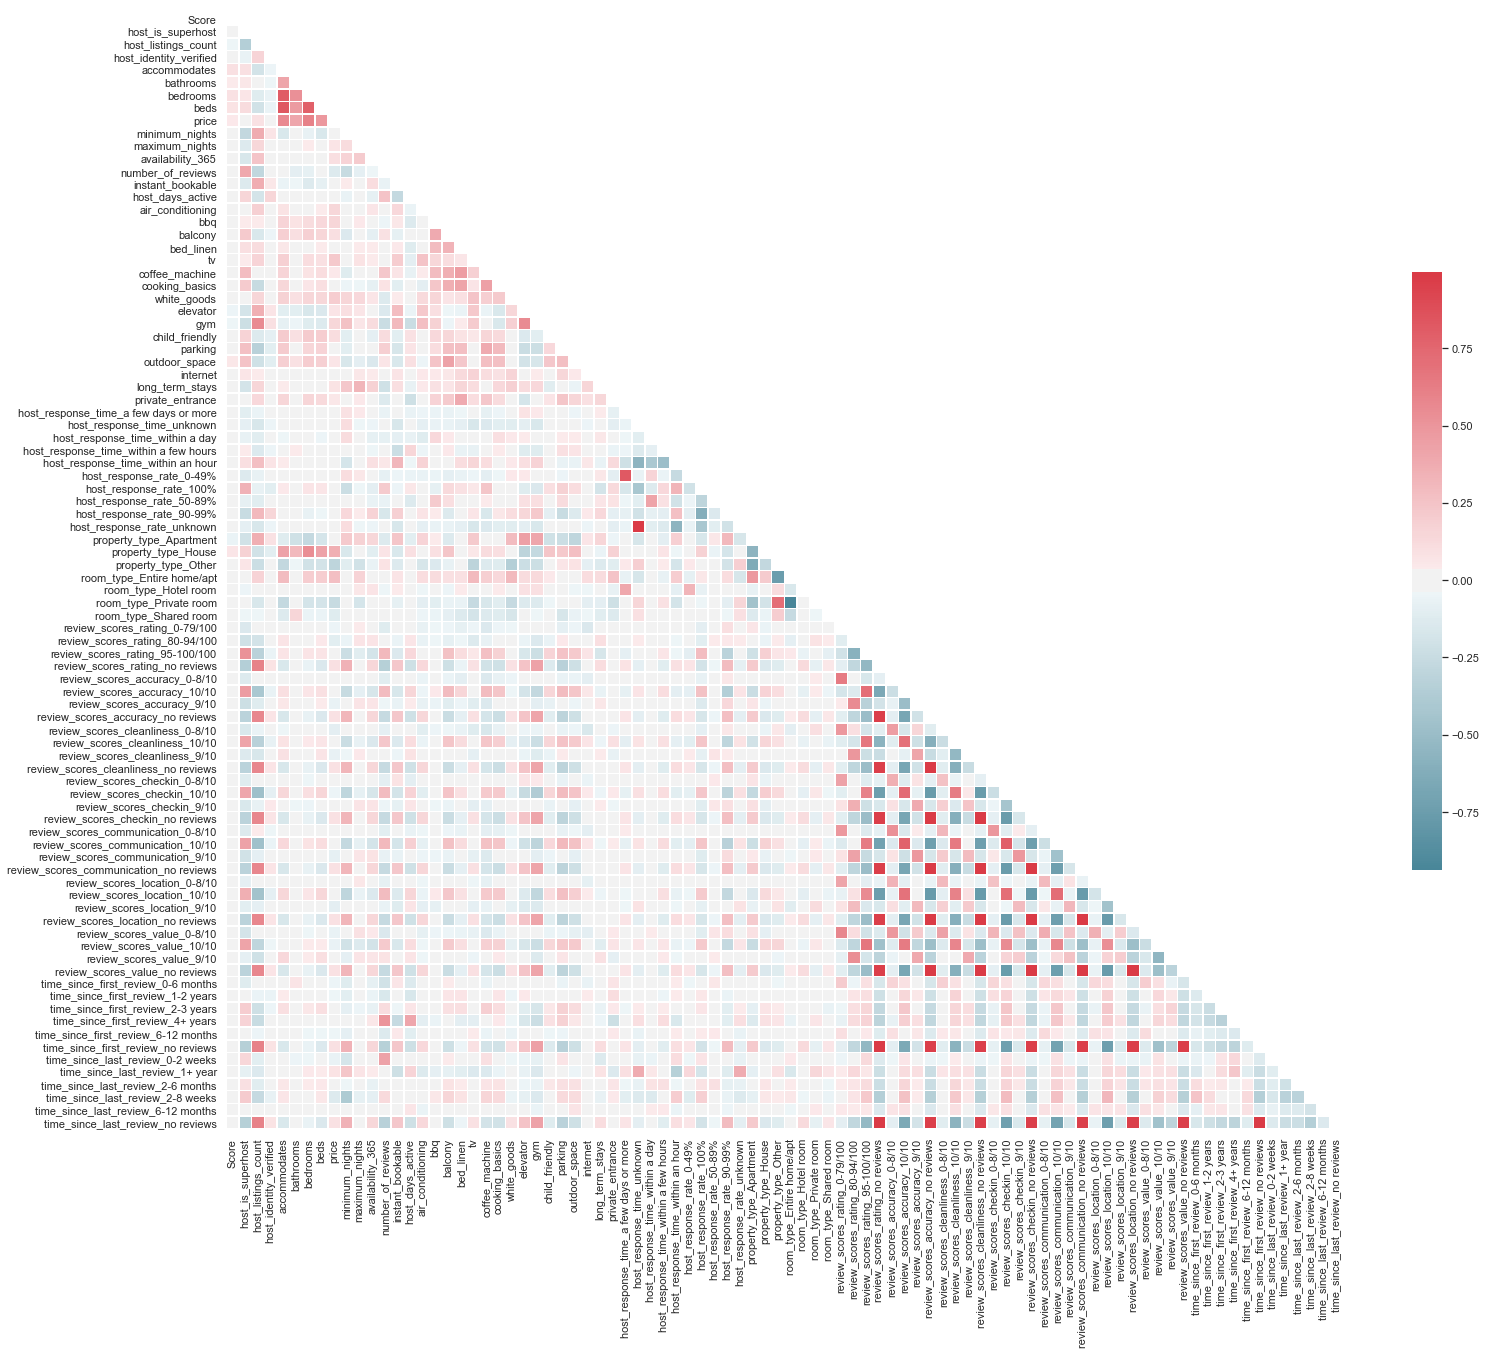

In [149]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.contains('Neighbourhood|neighbourhood')]), axis=1), figsize=(25,22))


Areas of multi-collinearity:

- `Beds`, `bedrooms`, `bathrooms` and the number of people that a property `accommodates` are highly correlated. The number of people accommodated has traditionally been a more high priority search parameter on Airbnb, as it is more relevant for private and shared rooms than the number of bedrooms (and is still the second highest priority parameter when searching on the site, after dates.

- Unsurprisingly, there are perfect correlations between `NaN reviews` (i.e. listings that are not reviewed yet) for different review categories, and first and last review times. `NaN` categories can therefore be dropped.

- The same is true of `host_response_rate_unknown` and `host_response_time_unknown`. One of these rates will be dropped.

- There is a correlation between `host_response_rate 0-49%` and `host_response_time_a few days or more`. One of these will be dropped.

- There are strong negative correlations between `property_type_House` and `property_type_Apartment`, and between `room_type_Private room` and `room_type_Entire_home_apt` (as these were the main two categories of their features before they were one-hot encoded). Although these are important categories, one of each will be dropped in order to reduce multi-collinearity (apartments and private rooms, as these are the second most common categories).

In [150]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'host_response_time_unknown',
           'host_response_time_a few days or more',
           'property_type_Apartment',
           'room_type_Shared room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

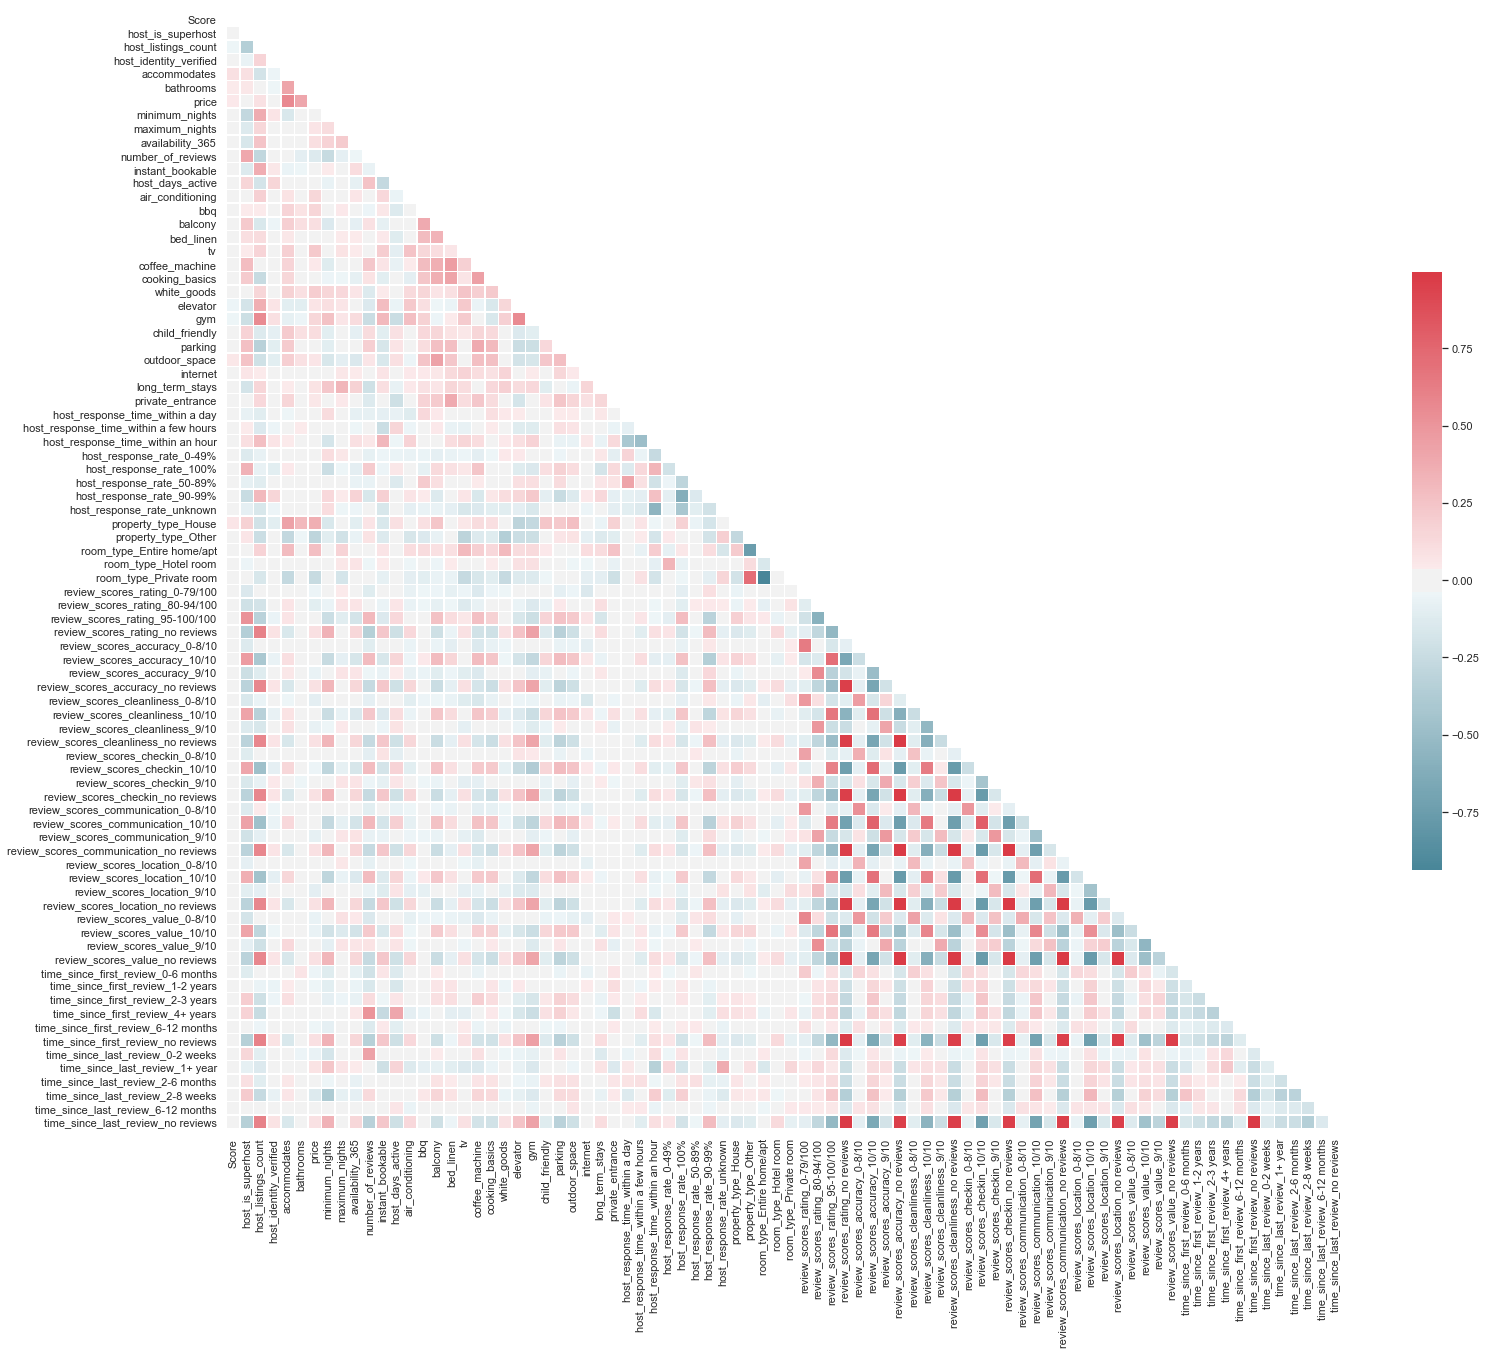

In [151]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.contains('Neighbourhood|neighbourhood')]), axis=1), figsize=(25,22))

There are still some fairly strong correlations between highly rated properties of different reviews categories - i.e. if a property gets a 10/10 for one category, it is likely to get a 10/10 for other categories. However, these will be left in for now and can be experimented with later to see if removing them improves the model.

#### Standardising and normalising

Other than `availability_365` and `host_days_active`, the remaining numerical features are all postively skewed and could benefit from log transformation.

In [152]:
numerical_columns = ['Score','accommodates', 'availability_365', 'bathrooms',
                     'host_days_active', 'host_listings_count', 'maximum_nights', 
                     'minimum_nights', 'number_of_reviews', 'price']

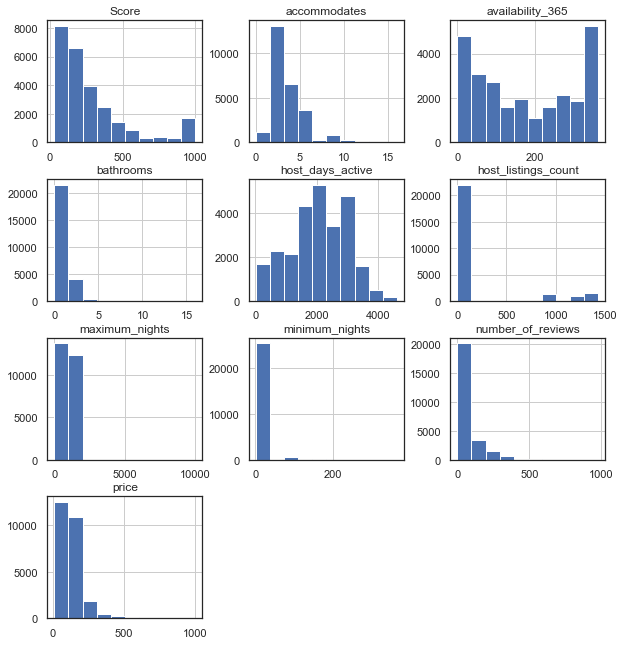

In [153]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [154]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

This appears to have helped some of the distributions, although some (e.g. `bathrooms`, `host_listing_count`) contain a large number of 0s, which means these features are not normally distributed. Most importantly, however, the target variable price now appears much more normally distributed.

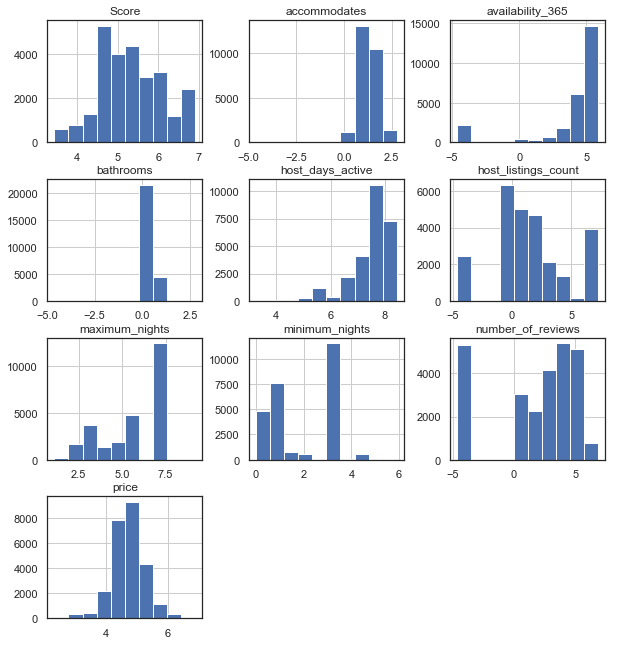

In [155]:
transformed_df[numerical_columns].hist(figsize=(10,11));

Finally, the predictive features `X` and the target feature `y` can be separated, and `X` will be scaled. `StandardScaler` from `sklearn` will be used, but the type of scaling used could be experimented with later to see if alternative versions yield better results.

That is, we’ll separate the features and the target variable for modeling. We will assign the features (explanatory variables) to `X` and the target variable to `y`. We use `scaler.fit_transform()`, as mentioned above, to transform the `y` variable for the model. `transformed_df.drop([features], axis=1)` tells pandas which columns we want to exclude. We won’t include `price` for obvious reasons, and `ID` is just an index with no relationship to `price`.

In [156]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

### 7. Modelling

Now that the data preprocessing is over, we can start applying different Supervised Machine Learning models. We will compare two models:

- A **Spatial Hedonic Price Model** (OLS Regression), with the `LinearRegression` from Scikit-Learn library
- The **Gradient Boosting method**, with the `XGBRegressor` from the XGBoost library

The evaluation metrics used will be mean squared error (for loss) and r-squared (for accuracy).

In [157]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) 

#### Model 1: Spatial Hedonic Price Model (HPM)

The hedonic model involves regressing observed asking-prices for the listing against those attributes of a property hypothesized to be determinants of the asking-price. It comes from **hedonic price theory** which assumes that a commodity, such as a house can be viewed as an aggregation of individual components or attributes [(Griliches, 1971)](https://www.hup.harvard.edu/catalog.php?isbn=9780674592582). Consumers are assumed to purchase goods embodying bundles of attributes that maximize their underlying utility functions [(Rosen, 1974)](https://econpapers.repec.org/article/ucpjpolec/v_3a82_3ay_3a1974_3ai_3a1_3ap_3a34-55.htm). 

In addition to the characteristics of the Airbnb listings, we add location features as they have been shown to be important factors in influencing the price (see [here](https://core.ac.uk/download/pdf/35467021.pdf), [here](https://www.aresjournals.org/doi/abs/10.5555/rees.32.3.d4713v80614728x1), [here](https://www-sciencedirect-com.ezproxy.napier.ac.uk/science/article/pii/S0169204610001775) and [here](https://www-sciencedirect-com.ezproxy.napier.ac.uk/science/article/pii/S0921800901002786) for examples). Ideally, Lagrange multiplier tests should be conducted to verify if there is spatial lag in the dependent variable and therefore a spatial lag model (see [this post](http://darribas.org/gds_scipy16/ipynb_md/08_spatial_regression.html) for spatial regression using  [Pysal](https://pypi.org/project/pysal/)) is preferred for estimating a spatial HPM. However, for the purposes of this post, we are only using a conventional OLS model for hedonic price estimation that includes spatial and locational features, but not a spatial lag that accounts for spatial dependence.

So, the first explanatory variables are the listings characteristics (`acommodates`, `bathrooms`, etc) and our second group of explanatory variables based on spatial and locational features are `Score`, which is the network distance to 5th nearest venue we computed with Pandana; and `Neighbourhood` belonging, `1` if the listing belongs to the specified neighbourhood, `0` otherwise.

In [158]:
hpm_reg_start = time.time()

# Create instance of the model, `LinearRegression` function from 
# Scikit-Learn and fit the model on the training data:

hpm_reg = LinearRegression()  
hpm_reg.fit(X_train, y_train) #training the algorithm

# Now that the model has been fit we can make predictions by calling 
# the predict command. We are making predictions on the testing set:
training_preds_hpm_reg = hpm_reg.predict(X_train)
val_preds_hpm_reg = hpm_reg.predict(X_test)

hpm_reg_end = time.time()

print(f"Time taken to run: {round((hpm_reg_end - hpm_reg_start)/60,1)} minutes")

# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg),4))

Time taken to run: 0.0 minutes

Training RMSE: 0.1012
Validation RMSE: 0.1038

Training r2: 0.674
Validation r2: 0.6654


This means that our features explain approximately 68% of the variance in our target variable. 

Interpreting the  ` mean_squared_error`value is somewhat more intuitive that the r-squared value. The RMSE measures the distance between our predicted values and actual values.

We can compare the actual output values for `X_test` with the predicted values in a dataframe:

In [159]:
y_test_array = np.array(list(y_test))
val_preds_hpm_reg_array = np.array(val_preds_hpm_reg)
hpm_df = pd.DataFrame({'Actual': y_test_array.flatten(), 'Predicted': val_preds_hpm_reg_array.flatten()})
hpm_df

Actual  Predicted
0     4.219508   4.561096
1     4.990433   4.782623
2     4.736198   4.486206
3     4.574711   4.630981
4     3.970292   4.240723
...        ...        ...
5211  5.521461   5.185608
5212  4.532599   4.634582
5213  4.248495   3.994995
5214  4.248495   4.507751
5215  5.666427   5.262207

[5216 rows x 2 columns]

And we can view this relationship graphically with a scatter plot:

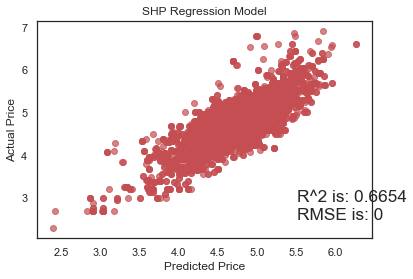

In [160]:
actual_values = y_test
plt.scatter(val_preds_hpm_reg, actual_values, alpha=.7,
            color='r') #alpha helps to show overlapping data
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    (round(r2_score(y_test, val_preds_hpm_reg),4)),
                    (round(mean_squared_error(y_test, val_preds_hpm_reg))),4)
plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('SHP Regression Model')
plt.show()

If our predicted values were identical to the actual values, this graph would be the straight line `y=x` because each predicted value x would be equal to each actual value y.

##### Improving our model

We can try using Ridge Regularization to decrease the influence of less important features. Ridge Regularization is a process which shrinks the regression coefficients of less important features.

We’ll once again instantiate the model. The Ridge Regularization model takes a parameter, alpha , which controls the strength of the regularization.

We’ll experiment by looping through a few different values of alpha, and see how this changes our results.

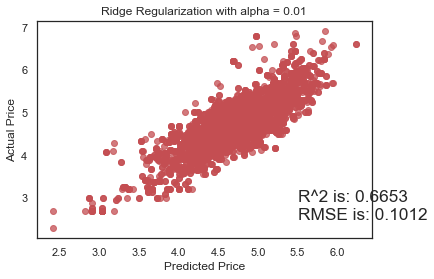

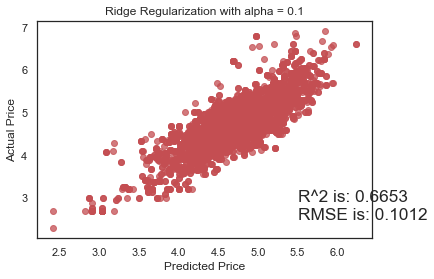

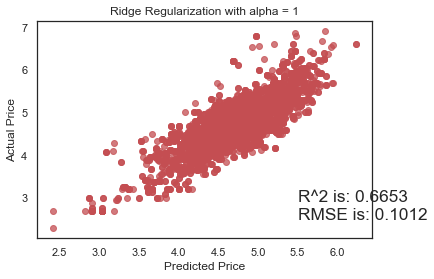

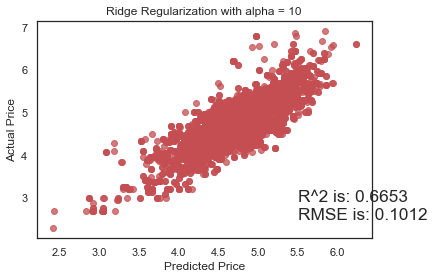

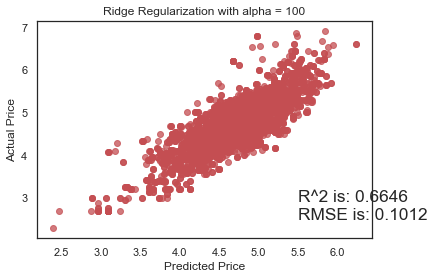

In [161]:
lr = linear_model.LinearRegression()

for i in range (-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)

    plt.scatter(preds_ridge, actual_values, alpha=.75, color='r')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                   round(ridge_model.score(X_test, y_test), 4),
                    round(mean_squared_error(y_train, training_preds_hpm_reg),4))
    plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')
    plt.show()

These models perform almost identically to the first model. In our case, adjusting the alpha did not substantially improve our model. 

#### Model 2:  Gradient boosted decision trees

Boosting is an ensemble technique where new models are added to correct the errors made by existing models. Models are added sequentially until no further improvements can be made. A popular example is the AdaBoost algorithm that weights data points that are hard to predict.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

XGBoost (e**X**treme **G**radient **Boost**ing) is an implementation of gradient boosted decision trees designed for speed and performance. Is a very popular algorithm that has recently been dominating applied machine learning for structured or tabular data.

This approach supports both regression and classification predictive modeling problems. For more information see [here](https://www.youtube.com/watch?v=Vly8xGnNiWs) to listen to Tianqi Chen, the creator of the XGBoost library.

This model will most likely provide the best achievable accuracy and a measure of feature importance compared to our Hedonic regression (other than possible small accuracy increases from hyper-parameter tuning) due to XGBoost's superior performance.

In [162]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.3 minutes

Training MSE: 0.006
Validation MSE: 0.0089

Training r2: 0.9805
Validation r2: 0.9712


This means that our features explain approximately 98% of the variance in our target variable. 

##### Feature importance

Apart from its superior performance, a benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

For more detailed information on how feature importance is calculated in boosted decision trees, see [this answer in StackOverflow](https://stats.stackexchange.com/questions/162162/relative-variable-importance-for-boosting).

In [163]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(10)

weight
room_type_Entire home/apt                    0.286757
property_type_Other                          0.115916
bathrooms                                    0.065351
Neighbourhood_Montlake                       0.033598
gym                                          0.028788
accommodates                                 0.016704
elevator                                     0.013548
neighbourhood_group_cleansed_Rainier Valley  0.012722
Neighbourhood_Pike-Market                    0.011228
tv                                           0.010761

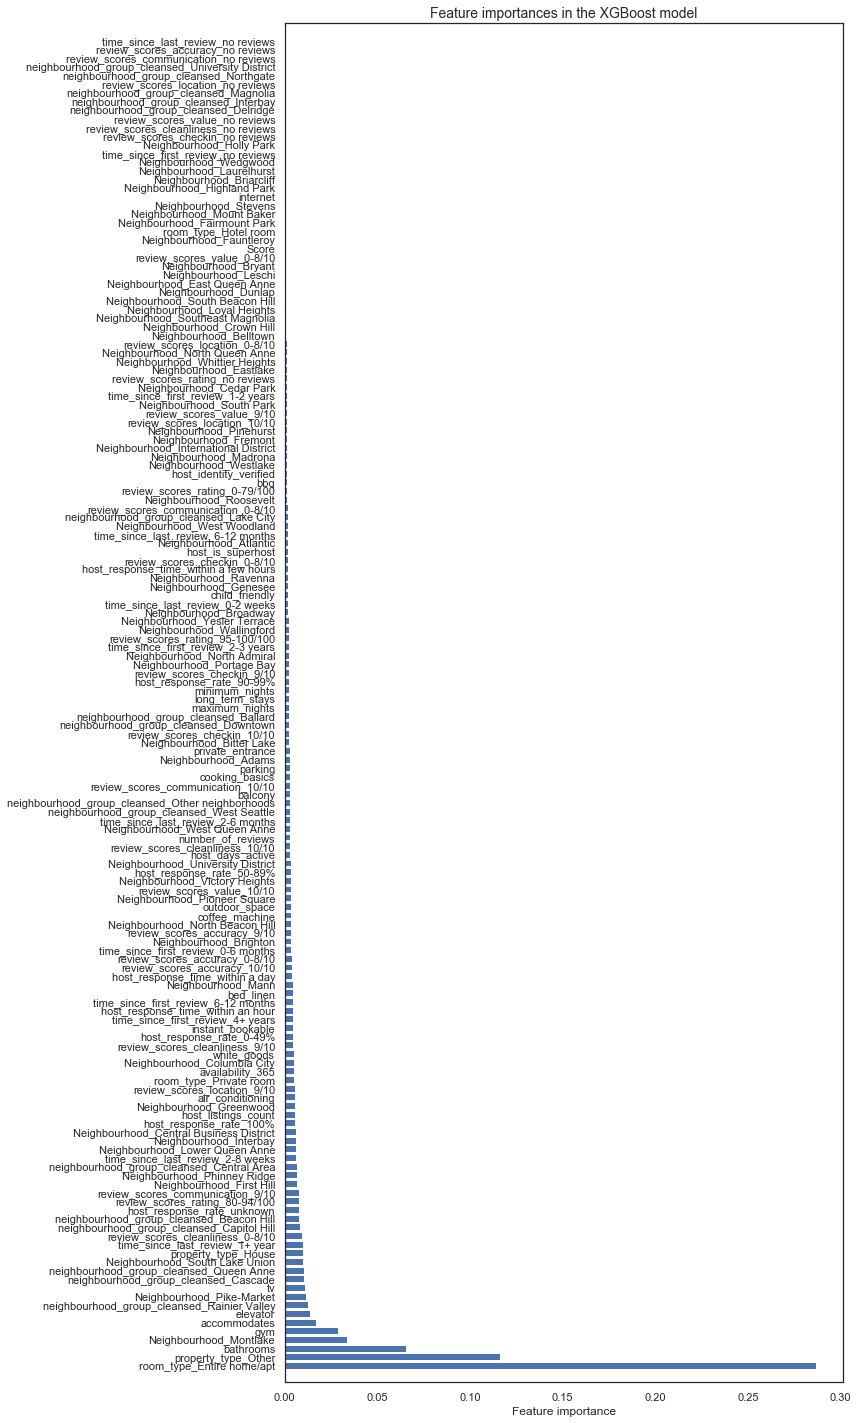

In [164]:
# Plotting feature importances
plt.figure(figsize=(10,25))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

About a good number of features have a feature importance of 0 in this XGBoost regression model, and could potentially be removed.

The top 8 most important features are:

1. If the rental is the entire flat or not (`room_type_Entire home/apt`)
2. If property type othen then home or apartment(`property_type_Other`)
3. The number of bathrooms (`bathrooms`)
4. Location (`Neighbourhood_Montlake`)
5. Avalibility of a gym (`gym`)
6. How many people a property can accomodate (`accomodates`)
7. Avalibility of an elevator (`elevator`)
8. Location (`Neighbourhood_group_cleaansed_Rainier Valley`)
9. Location (`Neighbourhood_Pike-Market`)
10. Avalibility of TV (`TV`)

The most important features the rental being the entire flat. Which makes sense. Asking price is higher if the offer is for the entire flat/house. This could also suggest that offering the flat/house as a whole, rather than each bedroom individually, may be better overall, given the large difference in importance compared to the second most important feature.

It is surprising that the second feature is bathroom, as that's one of the main things you would use to search for properties with in the first place.

It is not surprising that location features appear in the top ten. Although we can observe that belonging to a certain neighbourhood increases price. This is, it is likely renters put more weight in other's opinion about location instead of judging the location based on neighbourhood and venues around the property. This could also be because Seattle is a small and walkable city with good transportation services. Thus, location is not a major problem to reaching main touristic attractions and amenities.

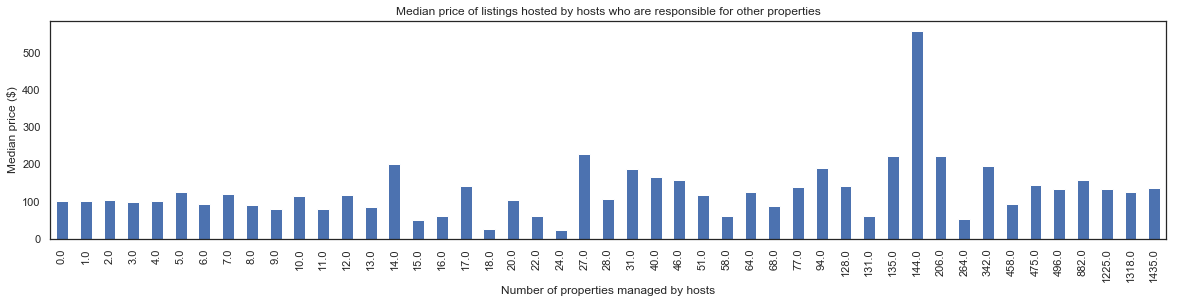

In [165]:
# Median price for different host listing counts
plt.figure()
df_merged.groupby('host_listings_count').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price ($)');

#### Improving models

In the 'Preparing the data for modeling' section above, it was noted that a lot of the review columns are reasonably highly correlated with each other. They were left in to see whether they would be useful after all. However, the feature importances graph produced by the XGBoost model suggest that they were of relatively low importance.

This model will drop review columns other than the overall review rating, and use the same Hedonic regression and XGBoost structure, in order to see whether this produces a better models.

Columns will be dropped from the existing `X_train` and `X_test` split, for consistency.

In [166]:
all_review = list(X_train.columns[X_train.columns.str.startswith("review_scores")])
review_to_keep = list(X_train.columns[X_train.columns.str.startswith("review_scores_rating")])
review_to_drop = [x for x in all_review if x not in review_to_keep]

X_train_short = X_train.drop(review_to_drop, axis=1)
X_test_short = X_test.drop(review_to_drop, axis=1)

#### Model 3: Hedonic regression with dropped columns

In [167]:
hpm_reg_start = time.time()

# Create instance of the model, `LinearRegression` function from 
# Scikit-Learn and fit the model on the training data:

hpm_reg2 = LinearRegression()  
hpm_reg2.fit(X_train, y_train) #training the algorithm

# Now that the model has been fit we can make predictions by calling 
# the predict command. We are making predictions on the testing set:
training_preds_hpm_reg2 = hpm_reg2.predict(X_train)
val_preds_hpm_reg2 = hpm_reg2.predict(X_test)

hpm_reg_end = time.time()

print(f"Time taken to run: {round((hpm_reg_end - hpm_reg_start)/60,1)} minutes")

# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg2),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg2),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg2),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg2),4))

Time taken to run: 0.0 minutes

Training RMSE: 0.1012
Validation RMSE: 0.1038

Training r2: 0.674
Validation r2: 0.6654


#### Model 4: XG Boost with dropped columns

In [168]:
xgb_reg_start = time.time()

xgb_reg2 = xgb.XGBRegressor()
xgb_reg2.fit(X_train, y_train)
training_preds_xgb_reg2 = xgb_reg2.predict(X_train)
val_preds_xgb_reg2 = xgb_reg2.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg2),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg2),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg2),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg2),4))

Time taken to run: 0.3 minutes

Training MSE: 0.006
Validation MSE: 0.0089

Training r2: 0.9805
Validation r2: 0.9712


Both Spatial Hedonic Regression and XGBoost perform almost exactly the same without the additional review columns.

Hence, because they are able to achieve the same performance with 18 fewer columns, the second models are the preferred models as they require less data and are less computationally expensive.

#### Final model selection

Overall, the XGBoost model (Model 4) is the preferred model, which performs better than both Spatial Hedonic Regression Models and just as good as the first model but is less computationally expensive. It could possibly be improved further with hyper-parameter tuning.

### Conclusions and Recommendations

The best performing model was able to predict 66.01% of the variation in price with an RMSE of 0.1. Which means we still have a remaining 34% unexplained. This could be due to several other features that are not part of our dataset or the need to analyse our features more closely.

For example, given the importance of customer reviews of the listing in determining price, perhaps a better understanding of the reviews could improve the prediction. Using Sentiment Analysis, a score between -1 (very negative sentiment) and 1 (very positive sentiment) can be assigned to each review per listing property. The scores are then averaged across all the reviews associated with that listing and the final scores can be included as a new feature in the model (see [here](https://arxiv.org/pdf/1907.12665.pdf) for an example).

It was noticeable that reviews about listing location, rather than the location features themselves, were higher in the feature importance list. Thus, this finding could perhaps be used by Airbnb hosts when writing their listing's description. Highlighting accessibility and location benefits of staying with them could perhaps benefit them and how much they can ask for their listing. 